# Projections GLOB vs HMA
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_future = slice('2015','2100')
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# HMA for full domain and the following for the above zones
zones = ['GLOB', 'GLOB-land', 'NH-land', 'HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [
        [slice(None), slice(None)], 
        [slice(None), slice(None)], 
        [slice(None), slice(0,90)], 
        [lonlim, latlim],
        [lonlim_HK, latlim_HK],
        [lonlim_HM, latlim_HM],
        [lonlim_TP, latlim_TP]
    ], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load results

In [3]:
list_models = u.get_model_names_projections()
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
variables = ['tas', 'snc', 'pr']

ym_past = [None]*len(variables)
ym_future = [None]*len(variables)

for i, var in enumerate(variables):
    ym_past[i] = xr.open_dataarray('results/projections_GLOB-HMA_'+var+'_'+period_past.start+'-'+period_past.start+'_mm_past_ym_zones.nc')
    ym_future[i] = xr.open_dataarray('results/projections_GLOB-HMA_'+var+'_'+period_future.start+'-'+period_future.start+'_mm_future_ym_zones_scenarios.nc')

## Compute values

In [4]:
variables = ['tas', 'snc', 'pr']

df = pd.DataFrame(
    index=[
        [season for season in seasons for i in range(len(scenarios))],
        scenarios*len(seasons)
    ],
    columns=[
        [var for var in variables for i in range(len(zones))],
        zones*len(variables)
    ]
)

# Initialiaze with empty list
for var in variables:
    for zone in zones:
        df[(var, zone)] = [[] for _ in range(len(df))]

df

tas                                    snc                    \
              GLOB GLOB-land NH-land HMA  HK  HM  TP GLOB GLOB-land NH-land   
Annual ssp126   []        []      []  []  []  []  []   []        []      []   
       ssp245   []        []      []  []  []  []  []   []        []      []   
       ssp370   []        []      []  []  []  []  []   []        []      []   
       ssp585   []        []      []  []  []  []  []   []        []      []   
DJFMA  ssp126   []        []      []  []  []  []  []   []        []      []   
       ssp245   []        []      []  []  []  []  []   []        []      []   
       ssp370   []        []      []  []  []  []  []   []        []      []   
       ssp585   []        []      []  []  []  []  []   []        []      []   
JJAS   ssp126   []        []      []  []  []  []  []   []        []      []   
       ssp245   []        []      []  []  []  []  []   []        []      []   
       ssp370   []        []      []  []  []  []  []   []        []      []   
       ssp585   []        []      []  []  []  []  []   []        []      []   

               ...               pr                                    
               ...  HK  HM  TP GLOB GLOB-land NH-land HMA  HK  HM  TP  
Annual ssp126  ...  []  []  []   []        []      []  []  []  []  []  
       ssp245  ...  []  []  []   []        []      []  []  []  []  []  
       ssp370  ...  []  []  []   []        []      []  []  []  []  []  
       ssp585  ...  []  []  []   []        []      []  []  []  []  []  
DJFMA  ssp126  ...  []  []  []   []        []      []  []  []  []  []  
       ssp245  ...  []  []  []   []        []      []  []  []  []  []  
       ssp370  ...  []  []  []   []        []      []  []  []  []  []  
       ssp585  ...  []  []  []   []        []      []  []  []  []  []  
JJAS   ssp126  ...  []  []  []   []        []      []  []  []  []  []  
       ssp245  ...  []  []  []   []        []      []  []  []  []  []  
       ssp370  ...  []  []  []   []        []      []  []  []  []  []  
       ssp585  ...  []  []  []   []        []      []  []  []  []  []  

[12 rows x 21 columns]

In [84]:
# list_models.remove('CanESM5')
# list_models.remove('IPSL-CM6A-LR')
# list_models.remove('CNRM-CM6-1')
# list_models.remove('CNRM-CM6-1-HR')
# list_models.remove('CNRM-ESM2-1')
list_models

['BCC-CSM2-MR',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']

In [5]:
%%time

for i, var in enumerate(variables):
    
    # clim_ref (zone: 7, season: 3, model: 10)
    clim_ref = ym_past[i].sel(year=slice('1995','2014')).mean('year')
    
    y_start = 2015
    delta = 20
    y_end = y_start + delta - 1
    step = 10

    while y_end < 2100:
        for model in list_models:
            
            # temp (scenario: 4, zone: 7, season: 3, model: 10)
            if var in ['snc', 'pr']: #relative
                temp = (ym_future[i].sel(
                    year=slice(str(y_start),str(y_end)), model=model
                ).mean('year') - clim_ref.sel(model=model)) / clim_ref.sel(model=model) * 100
            else:
                temp = ym_future[i].sel(
                    year=slice(str(y_start),str(y_end)), model=model
                ).mean('year') - clim_ref.sel(model=model)

            for scenario in scenarios:
                for zone in zones:
                    for season in seasons:
                        df.loc[(season, scenario), (var, zone)].append(
                            temp.sel(season=season, scenario=scenario, zone=zone).values.tolist()
                        )

        y_start += step
        y_end = y_start + delta - 1

CPU times: user 21.8 s, sys: 0 ns, total: 21.8 s
Wall time: 21.8 s


In [6]:
# Check 7 period for 10 models = 70
for var in ['tas']:
    for zone in zones:
        print (zone)
        for scenario in scenarios:
            print(scenario + ' : ' + str(len(df.loc[('Annual', scenario), (var, zone)])))

GLOB
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
GLOB-land
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
NH-land
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
HMA
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
HK
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
HM
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70
TP
ssp126 : 70
ssp245 : 70
ssp370 : 70
ssp585 : 70


## Plot

## var vs var

***********
*** tas ***
***********
***********
*** snc ***
***********
***********
*** pr ***
***********


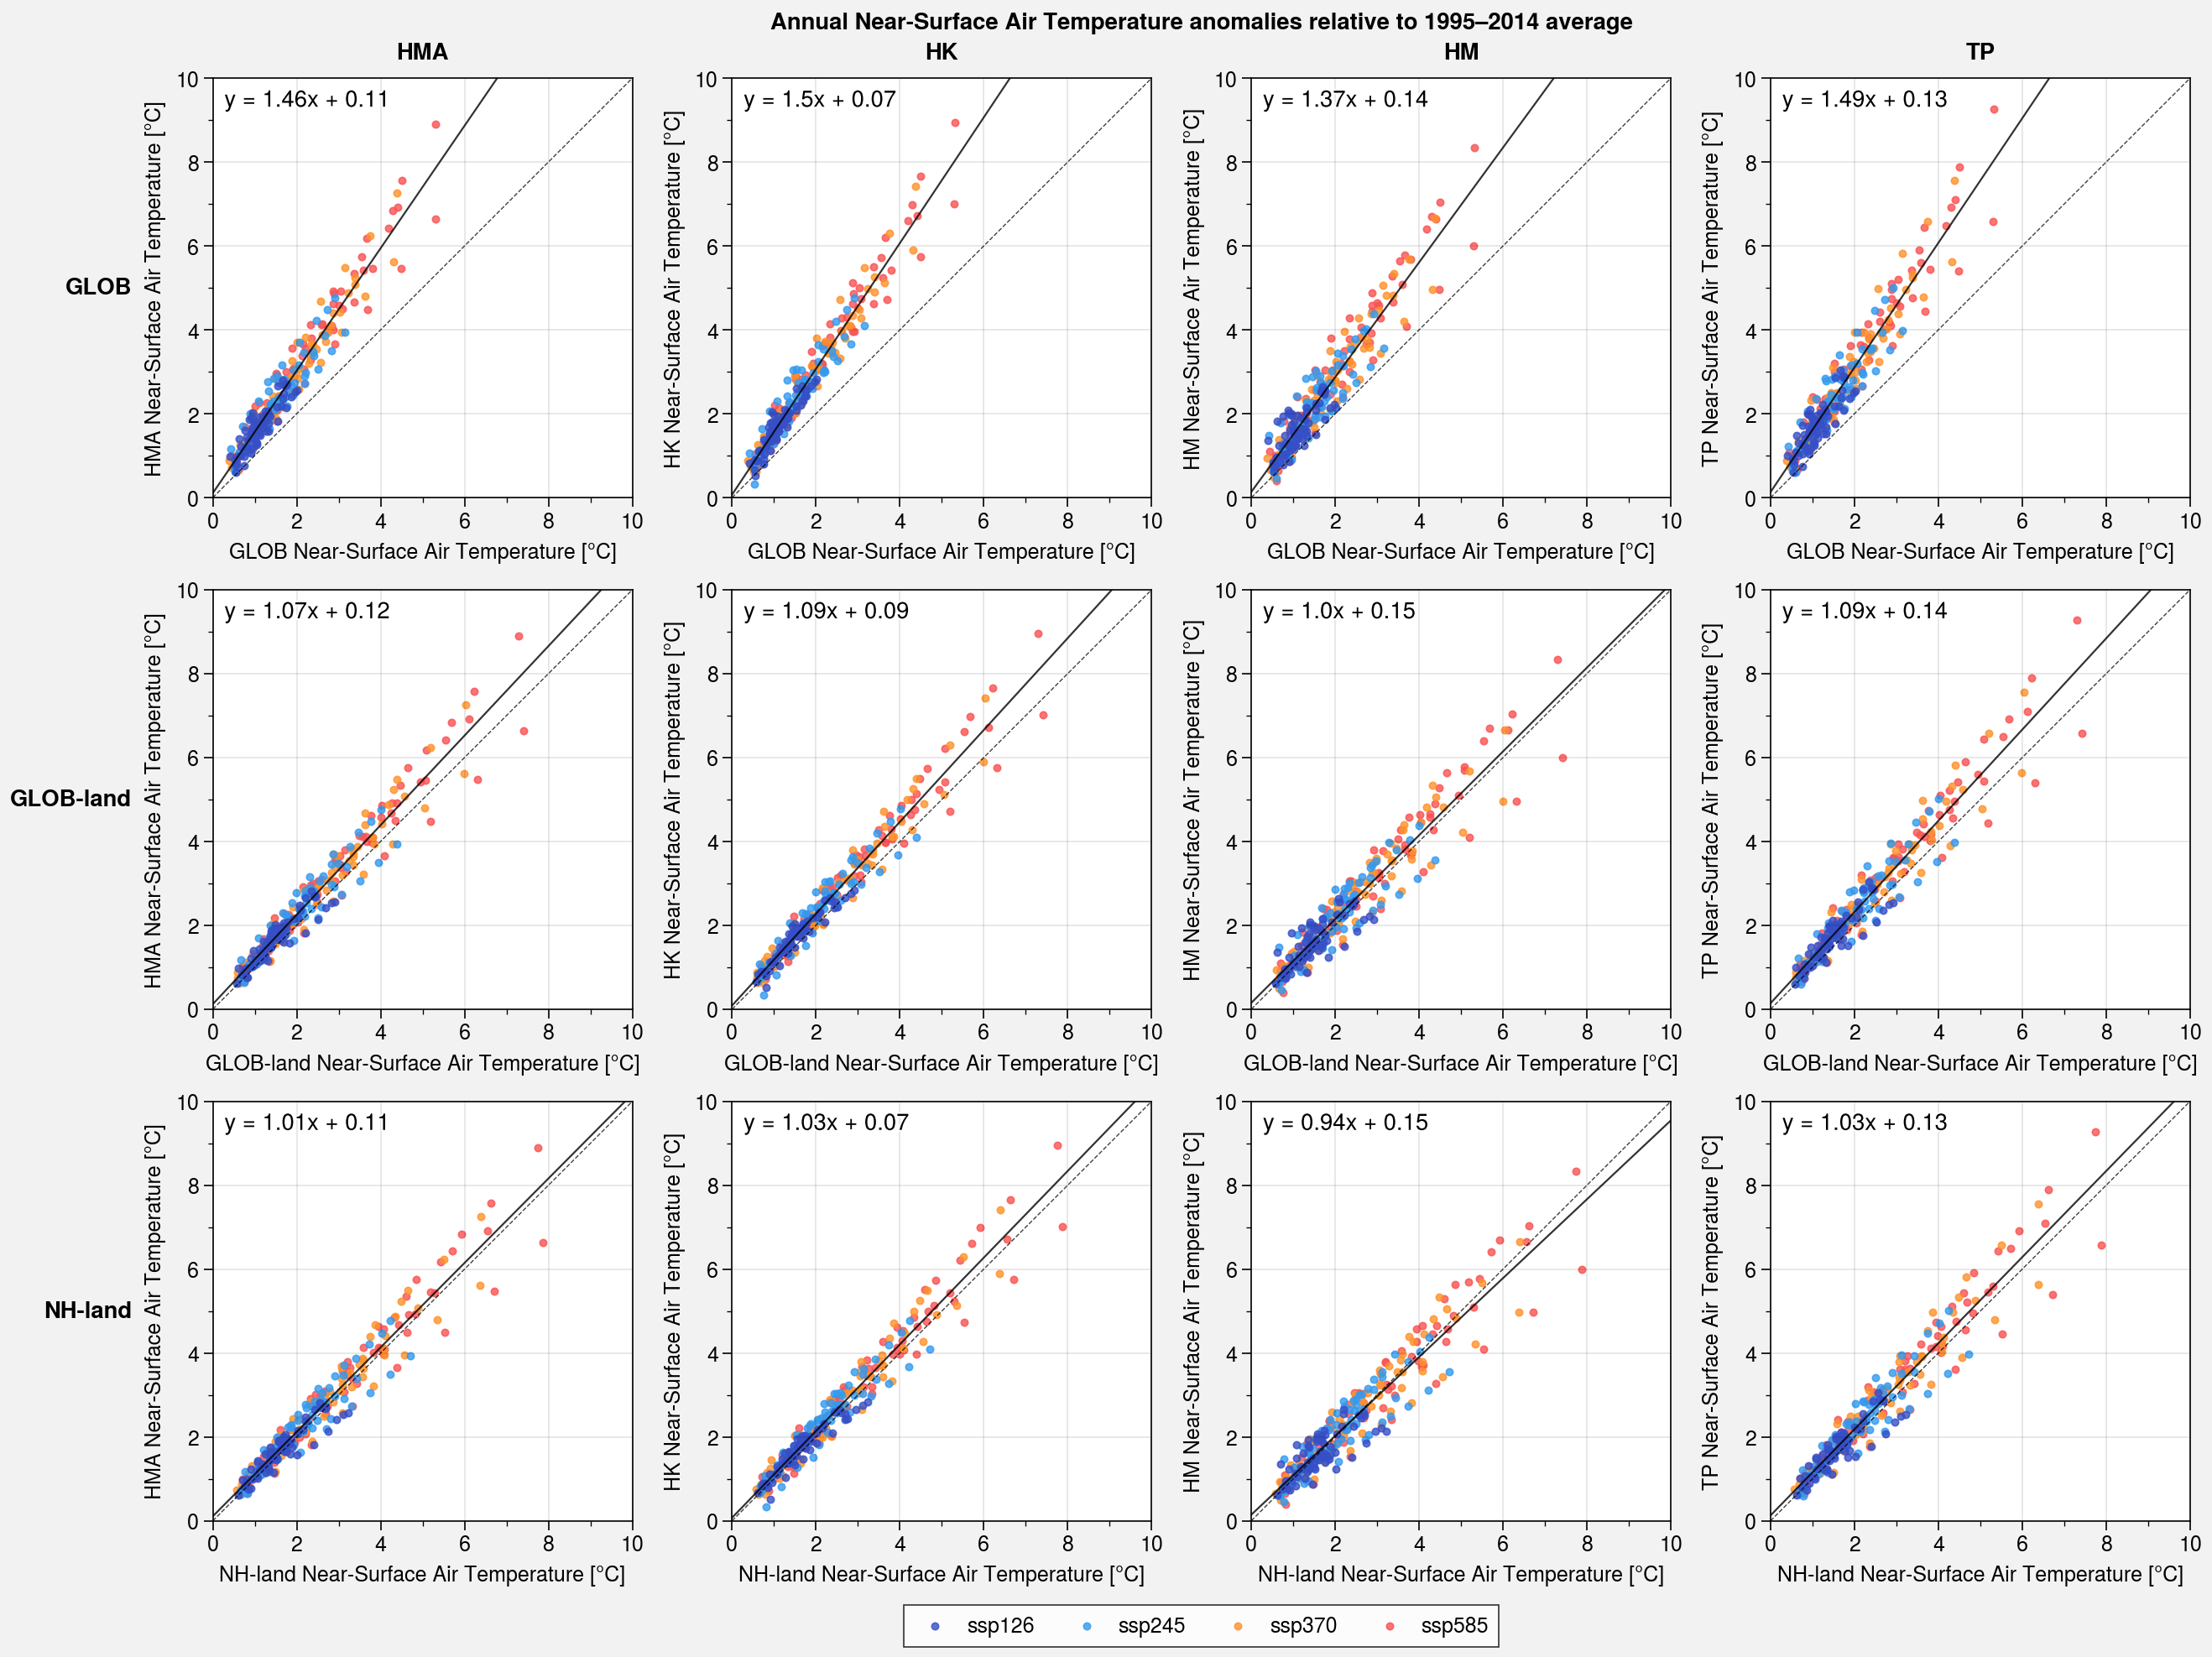

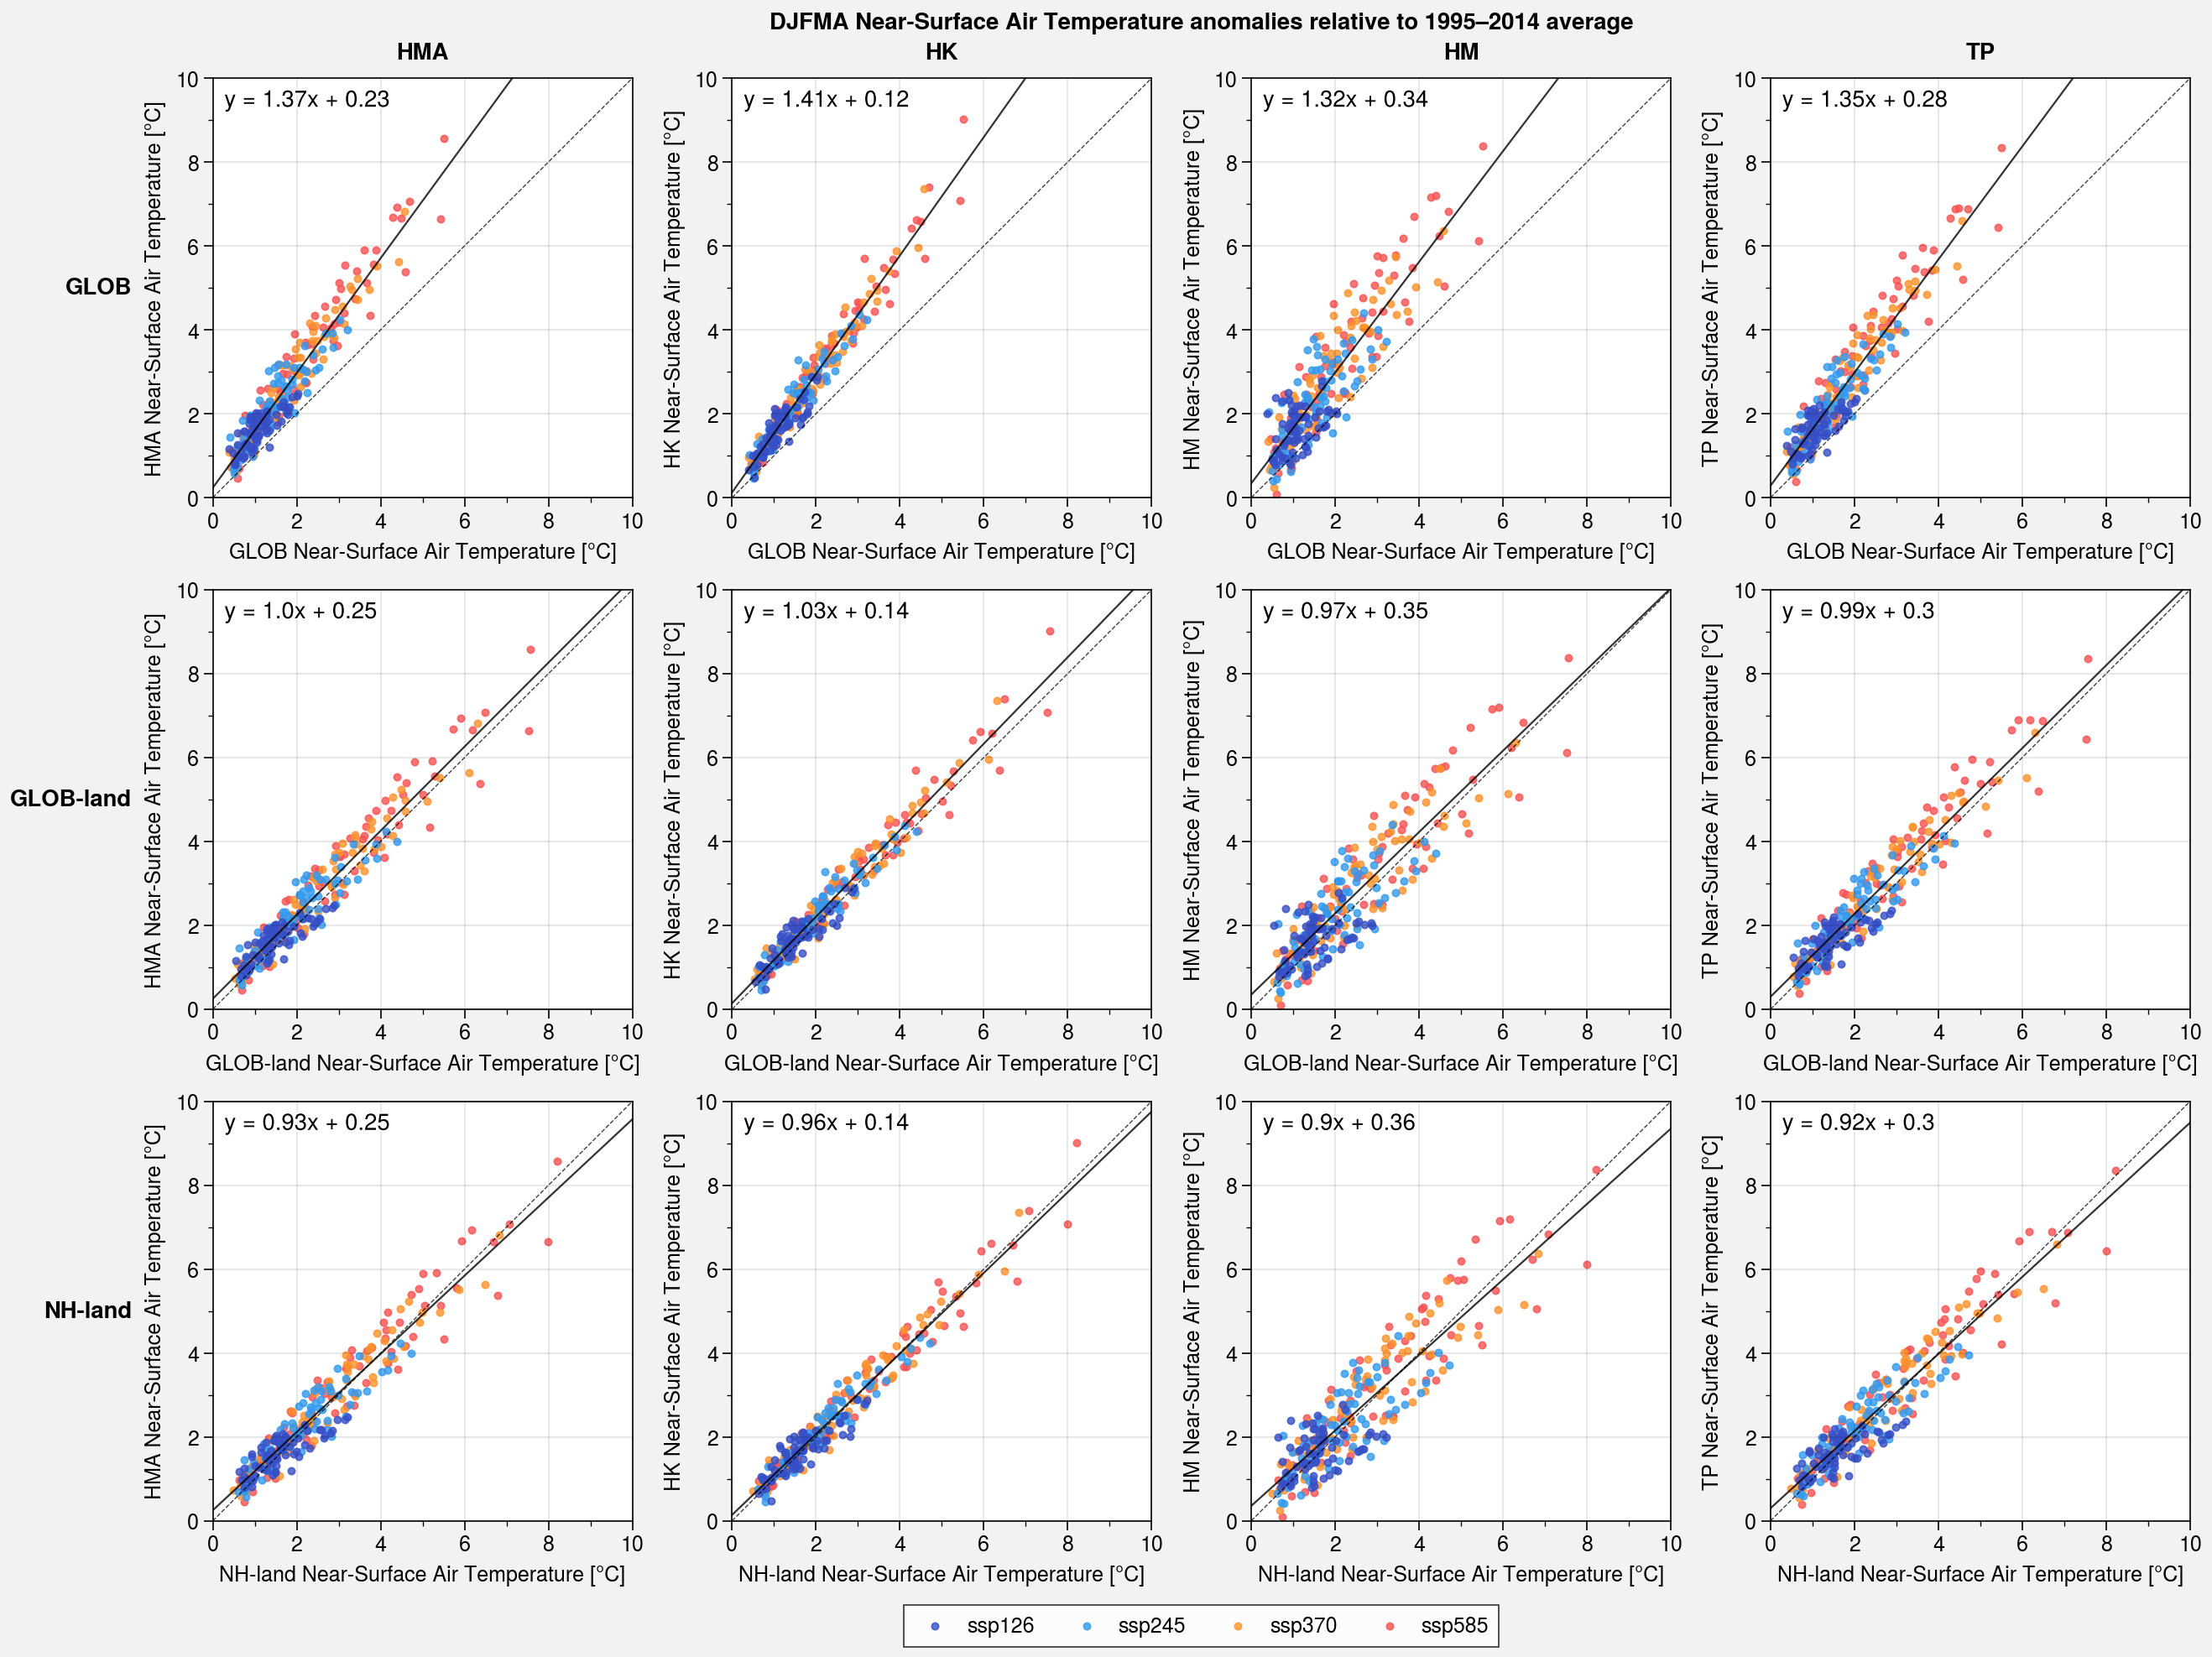

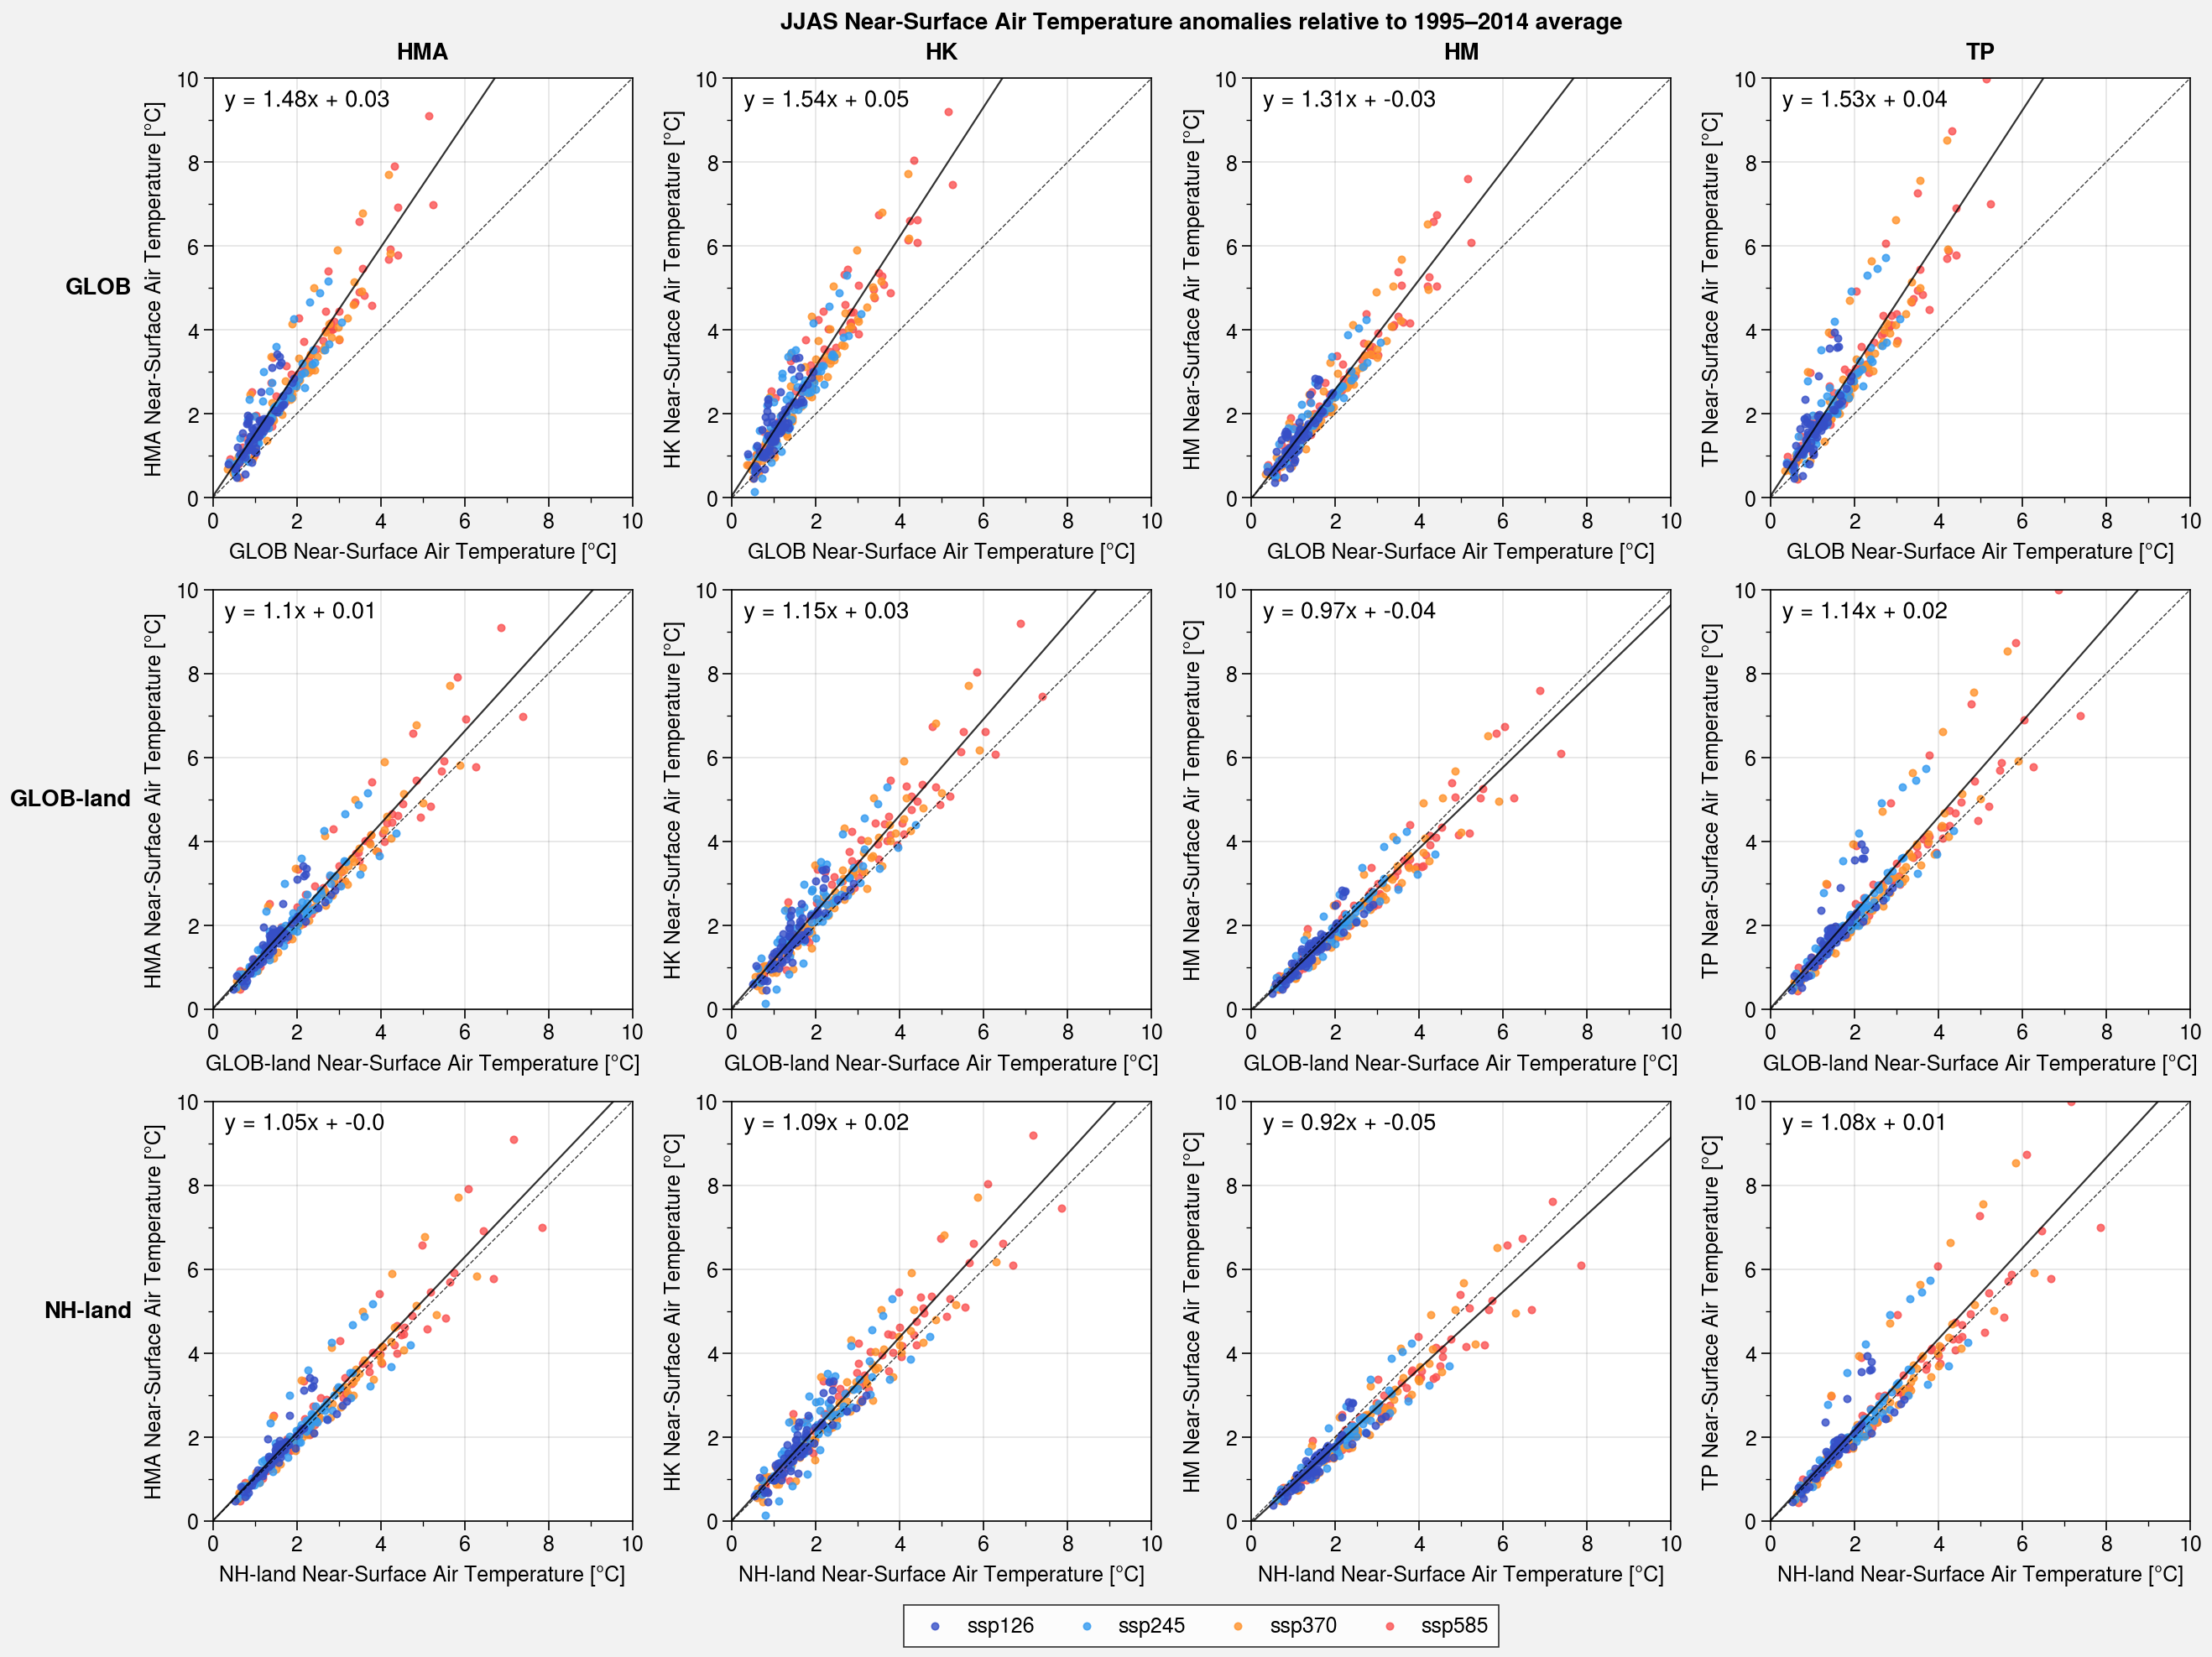

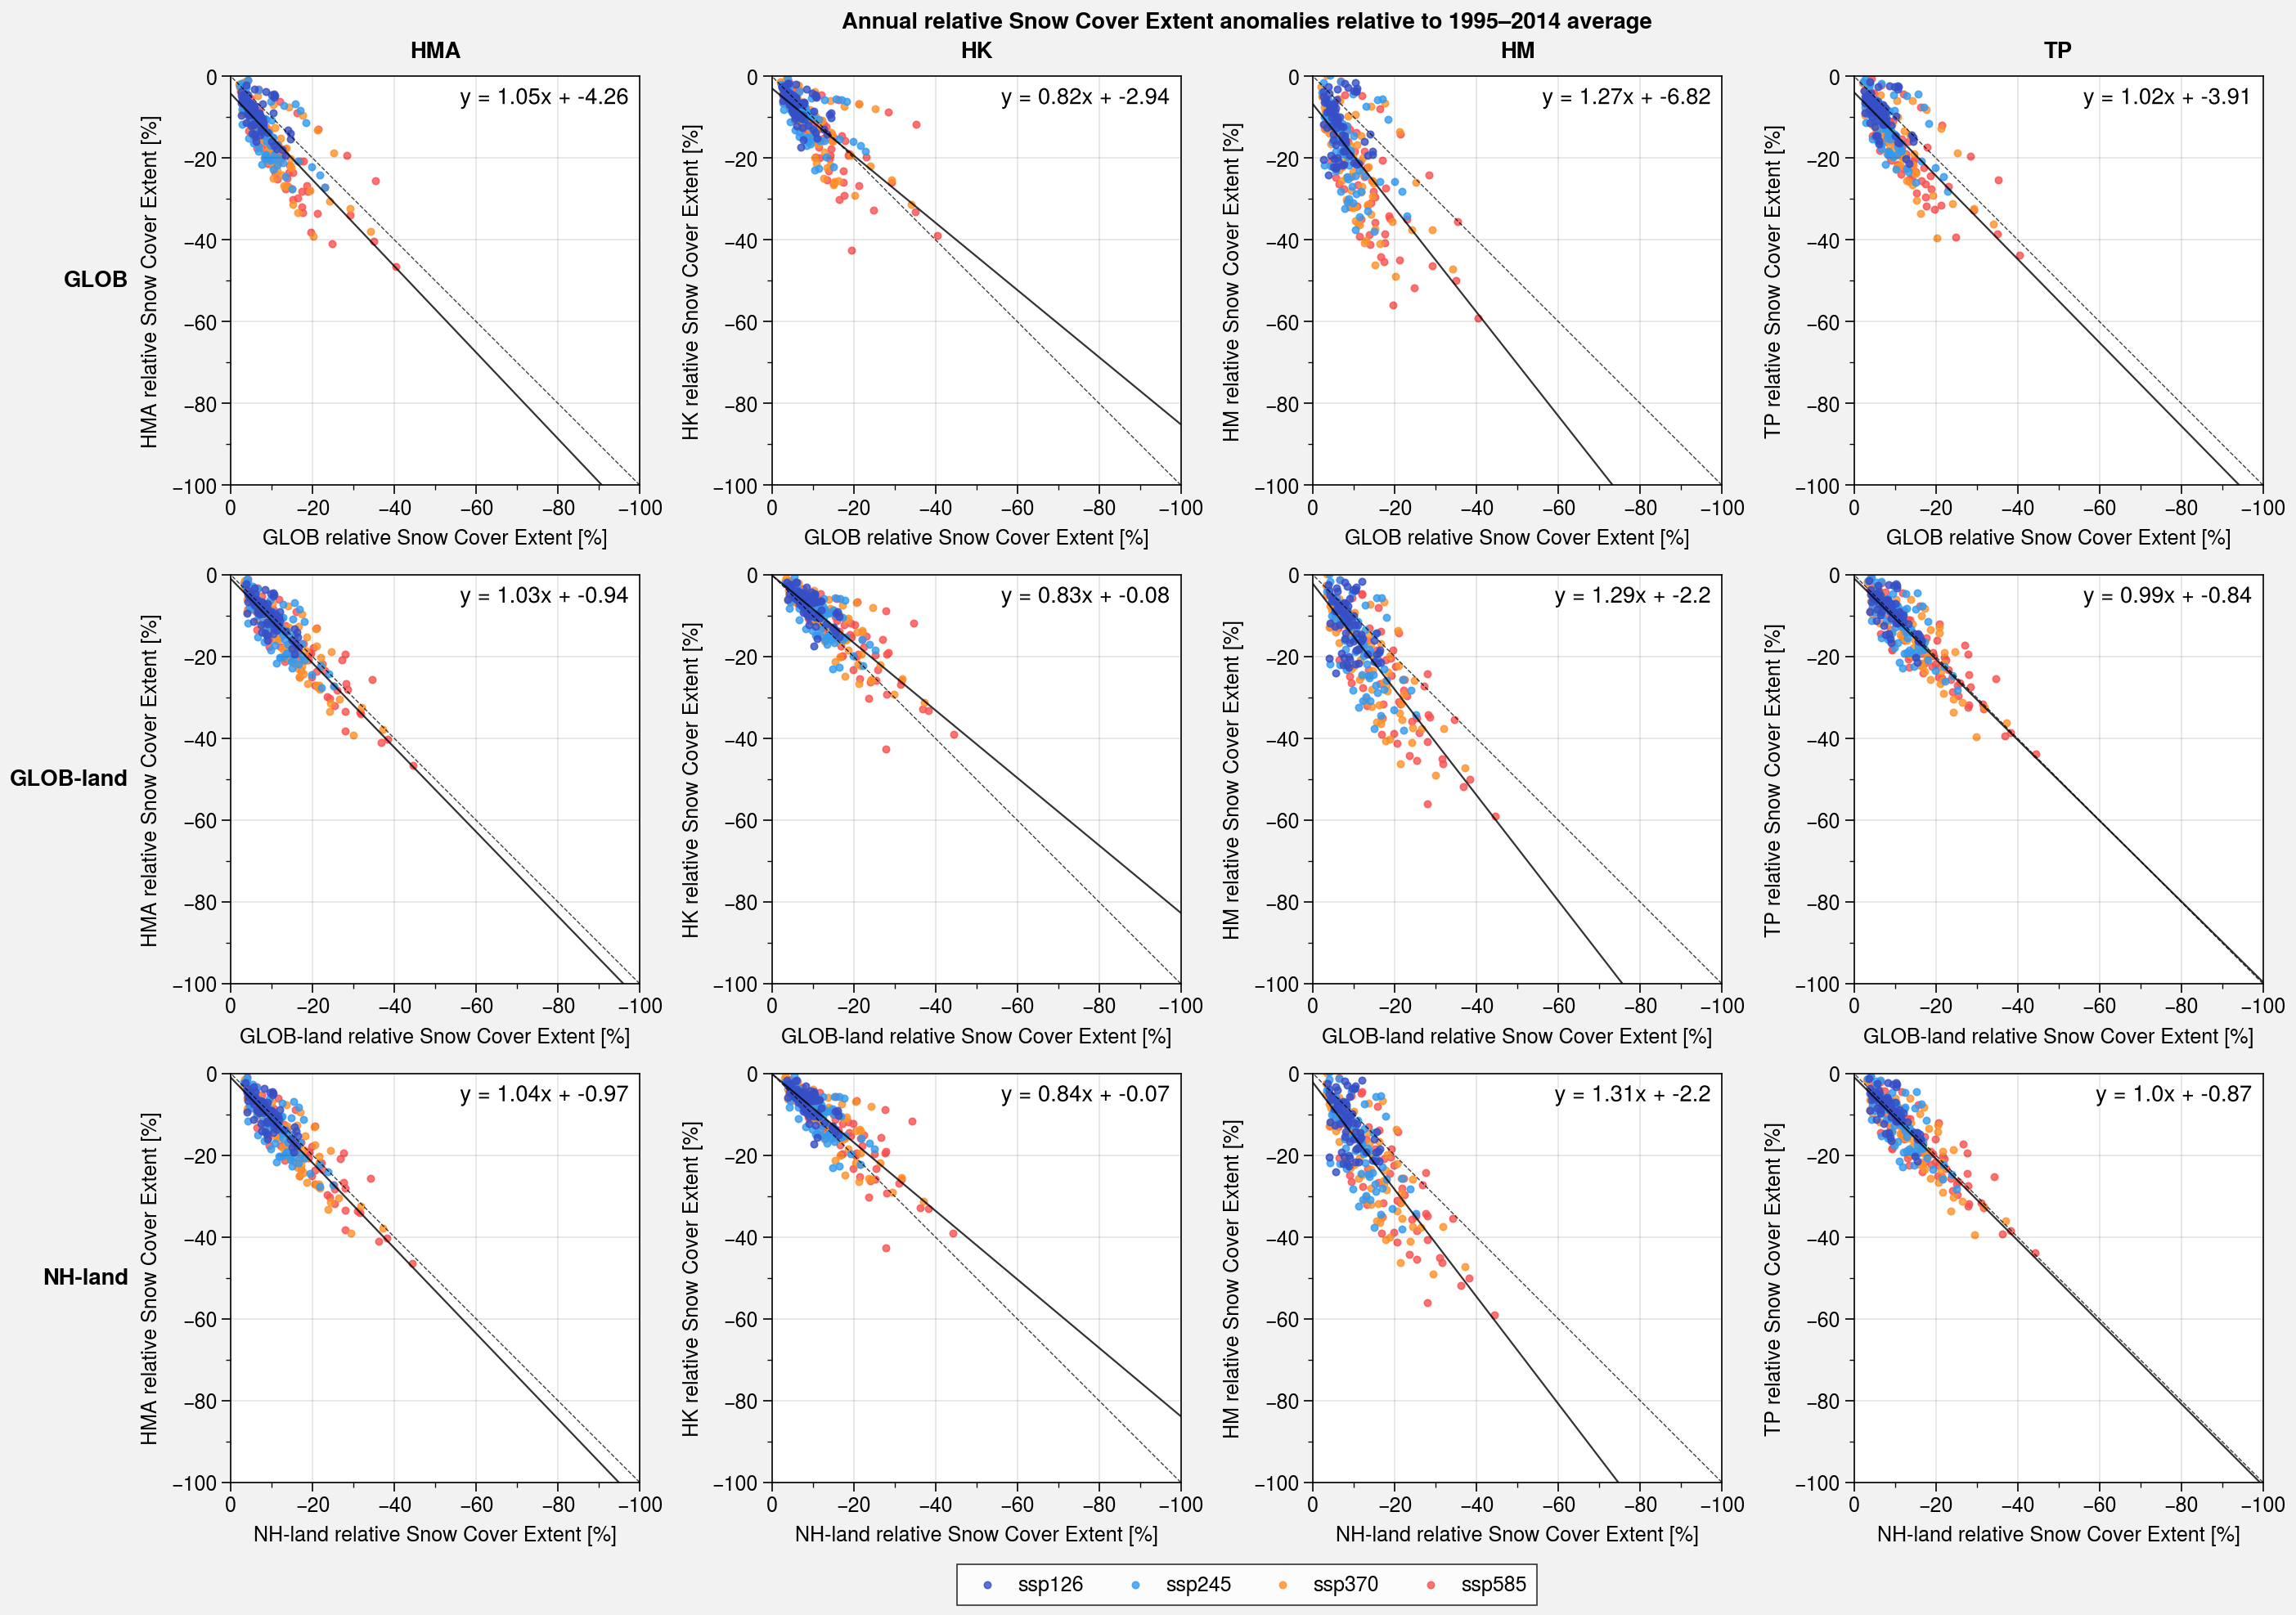

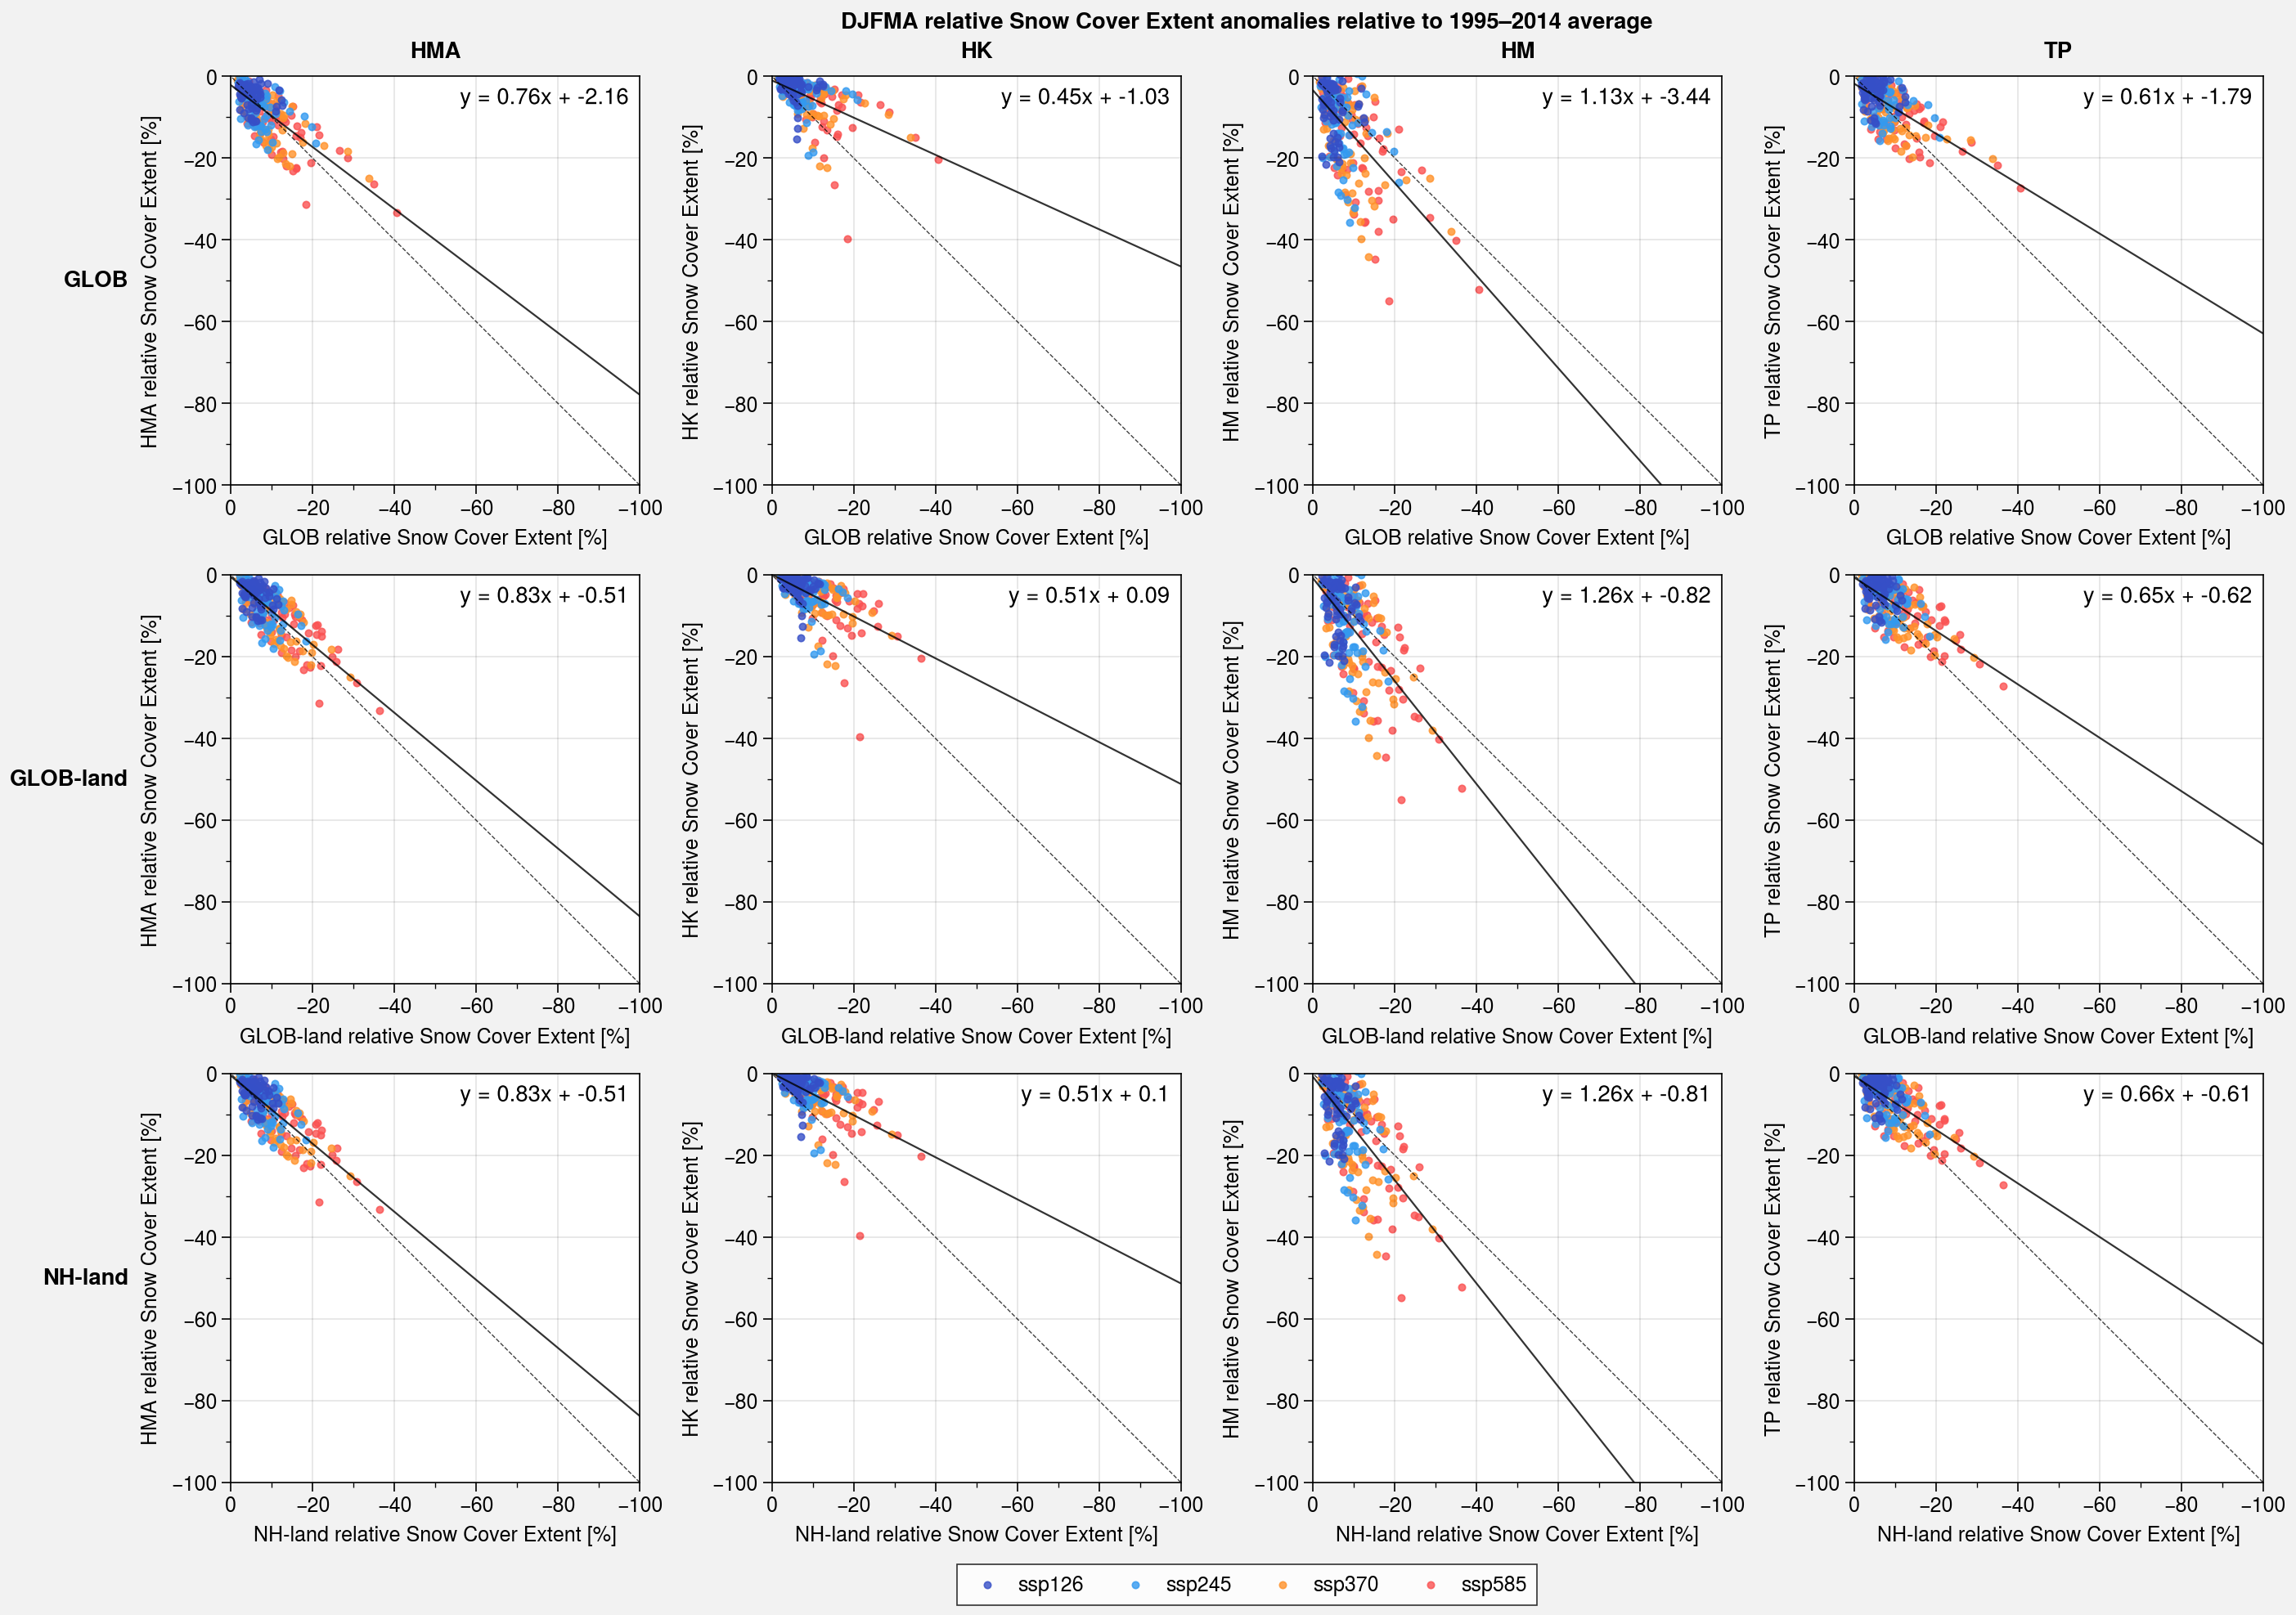

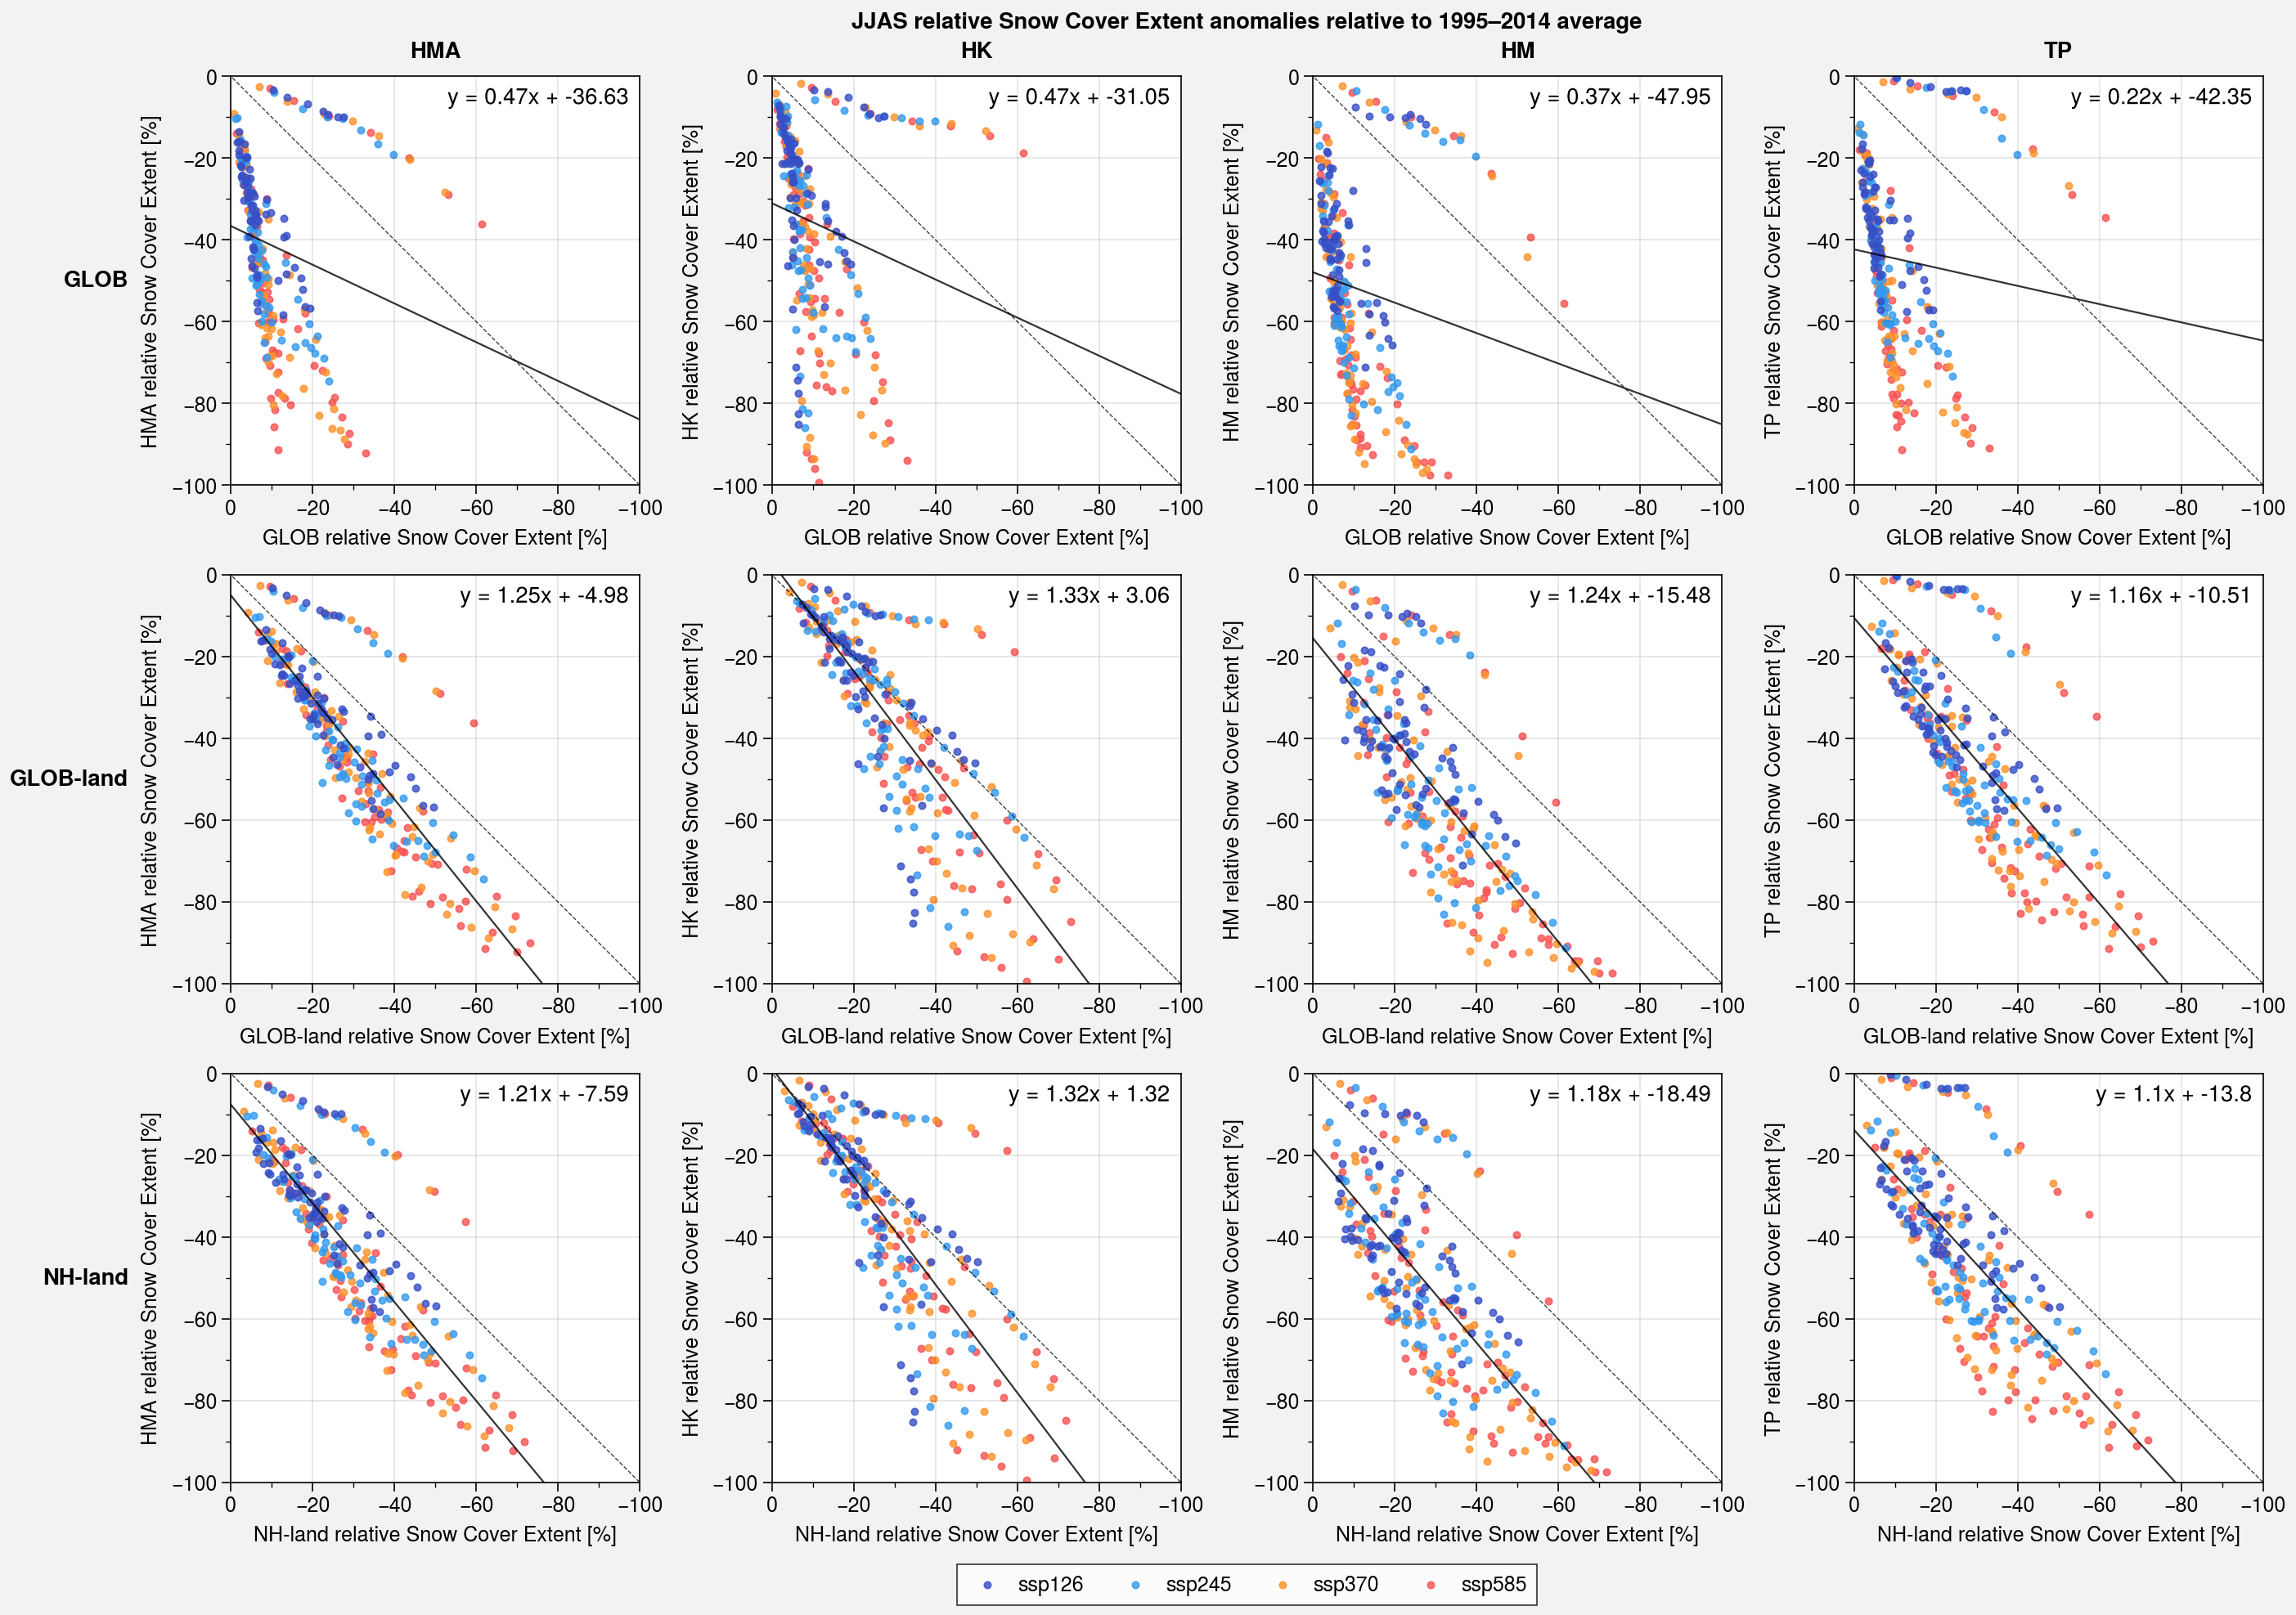

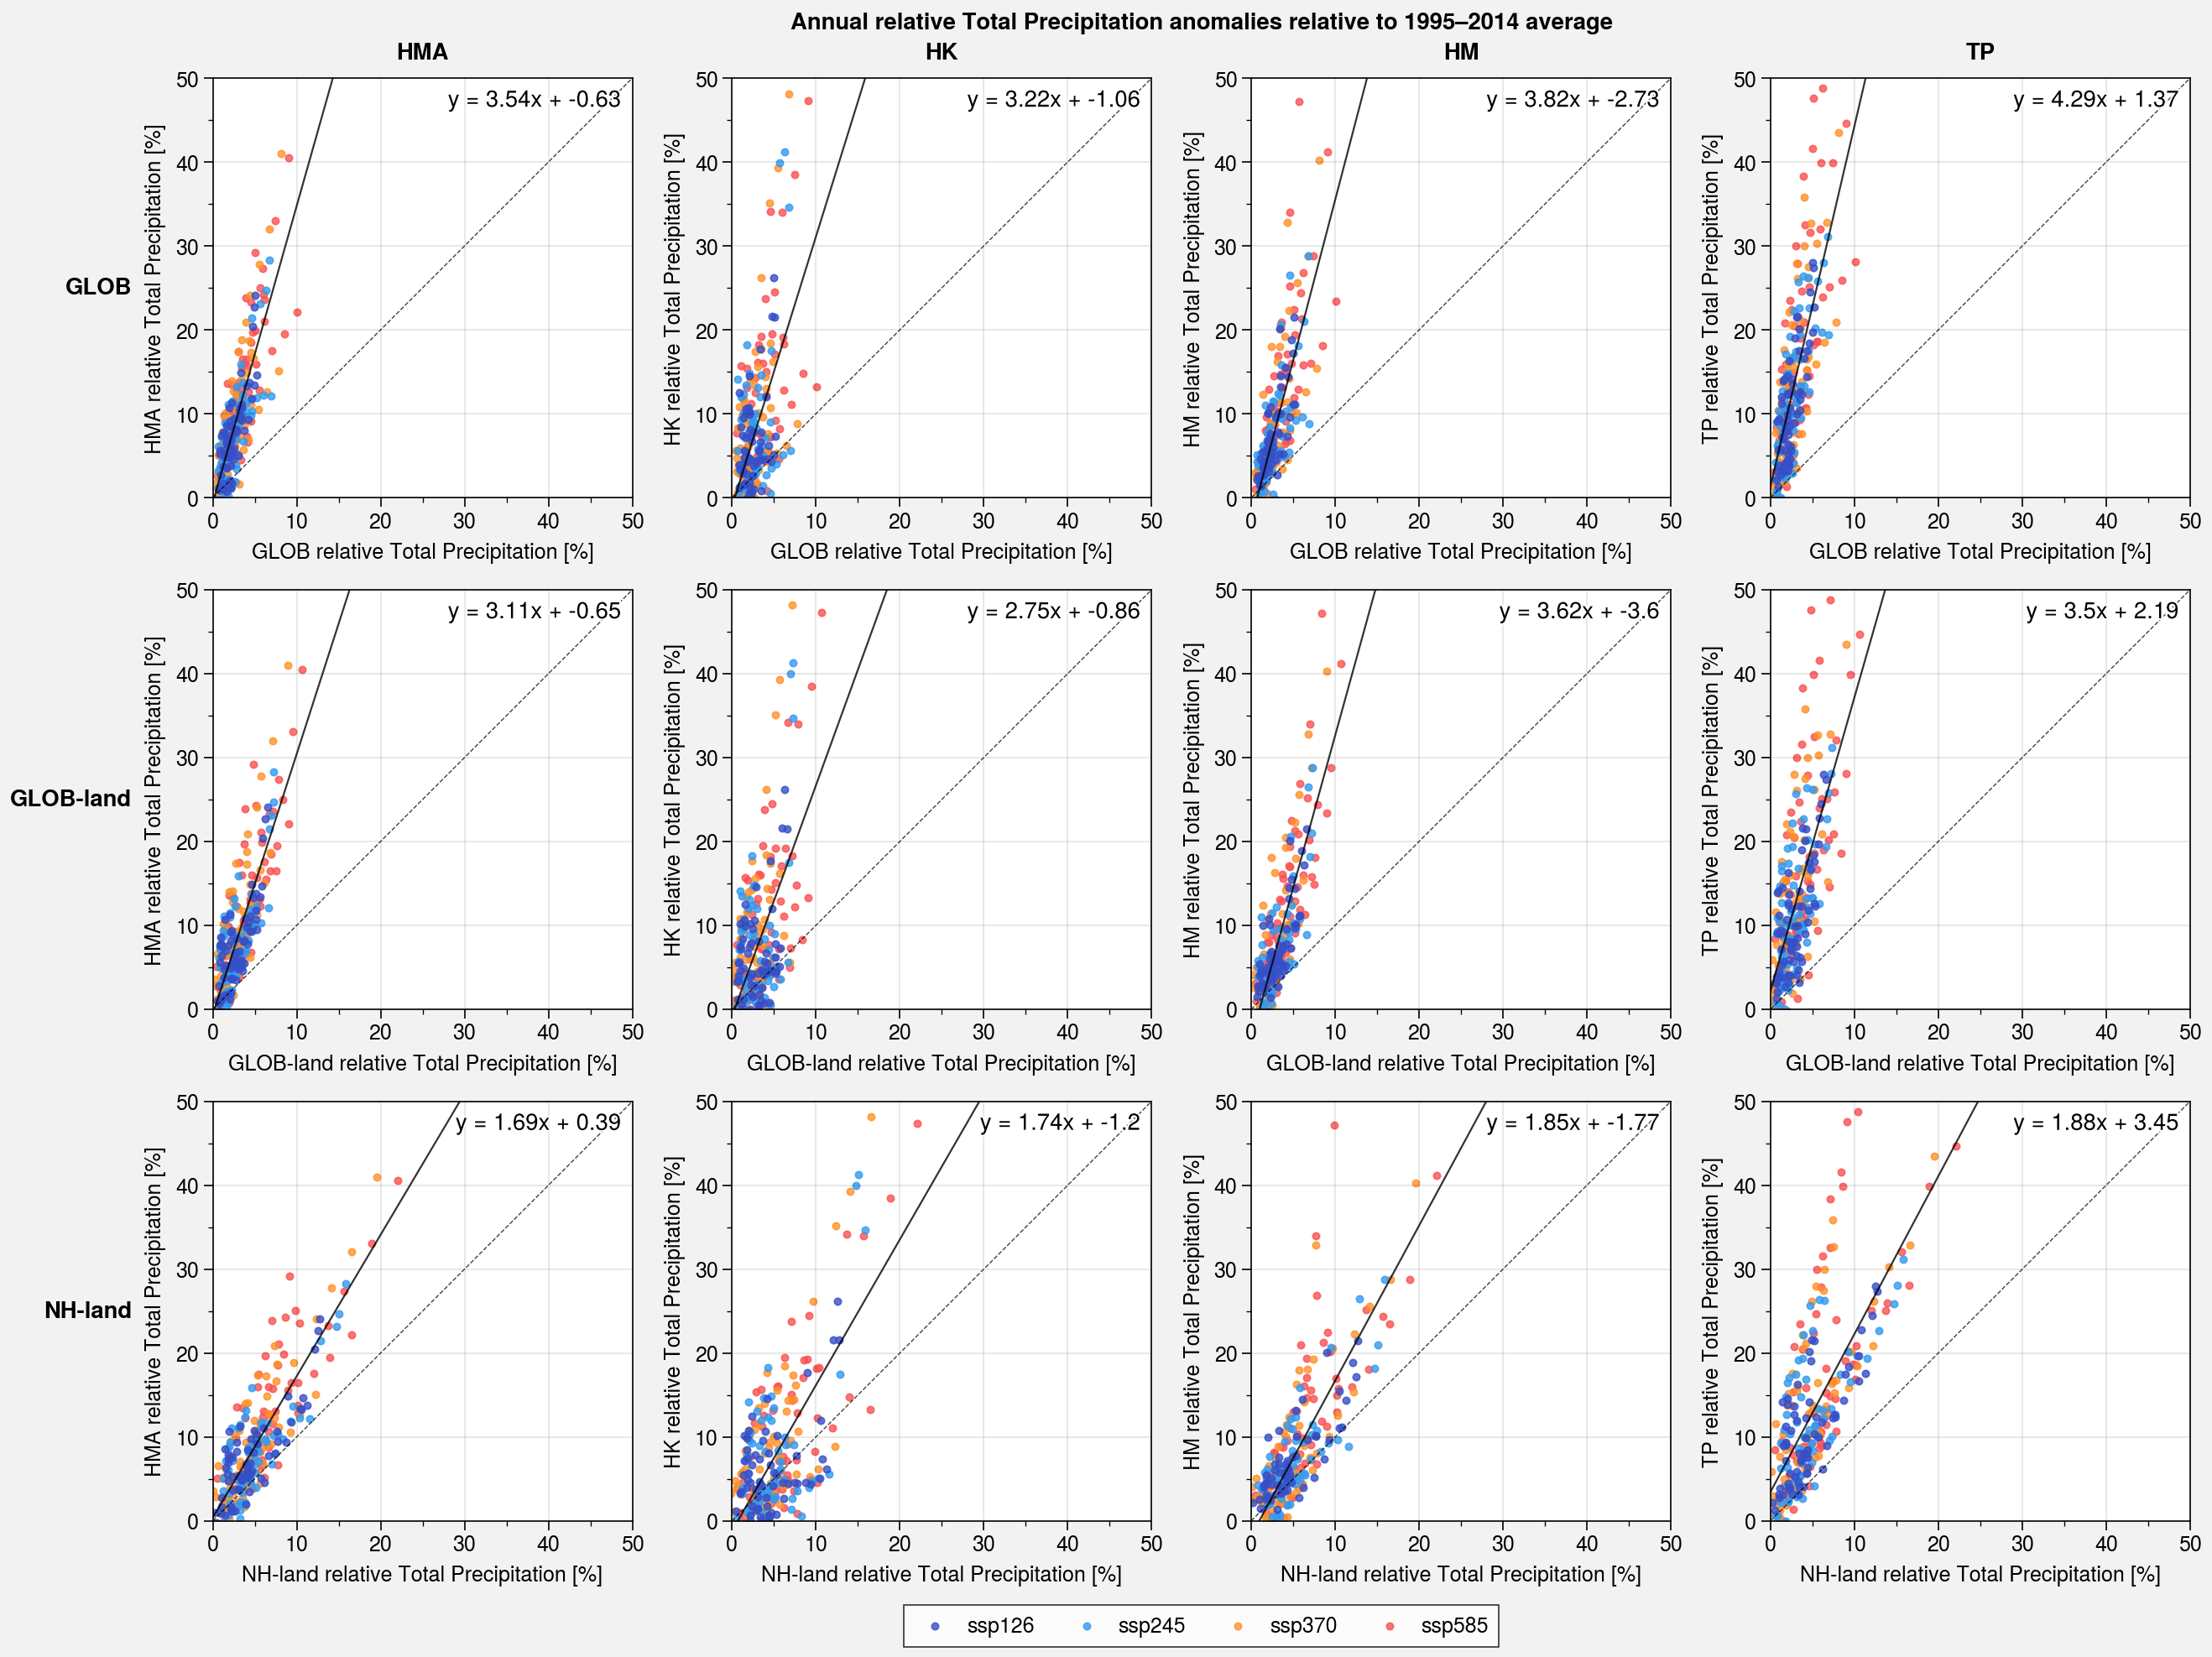

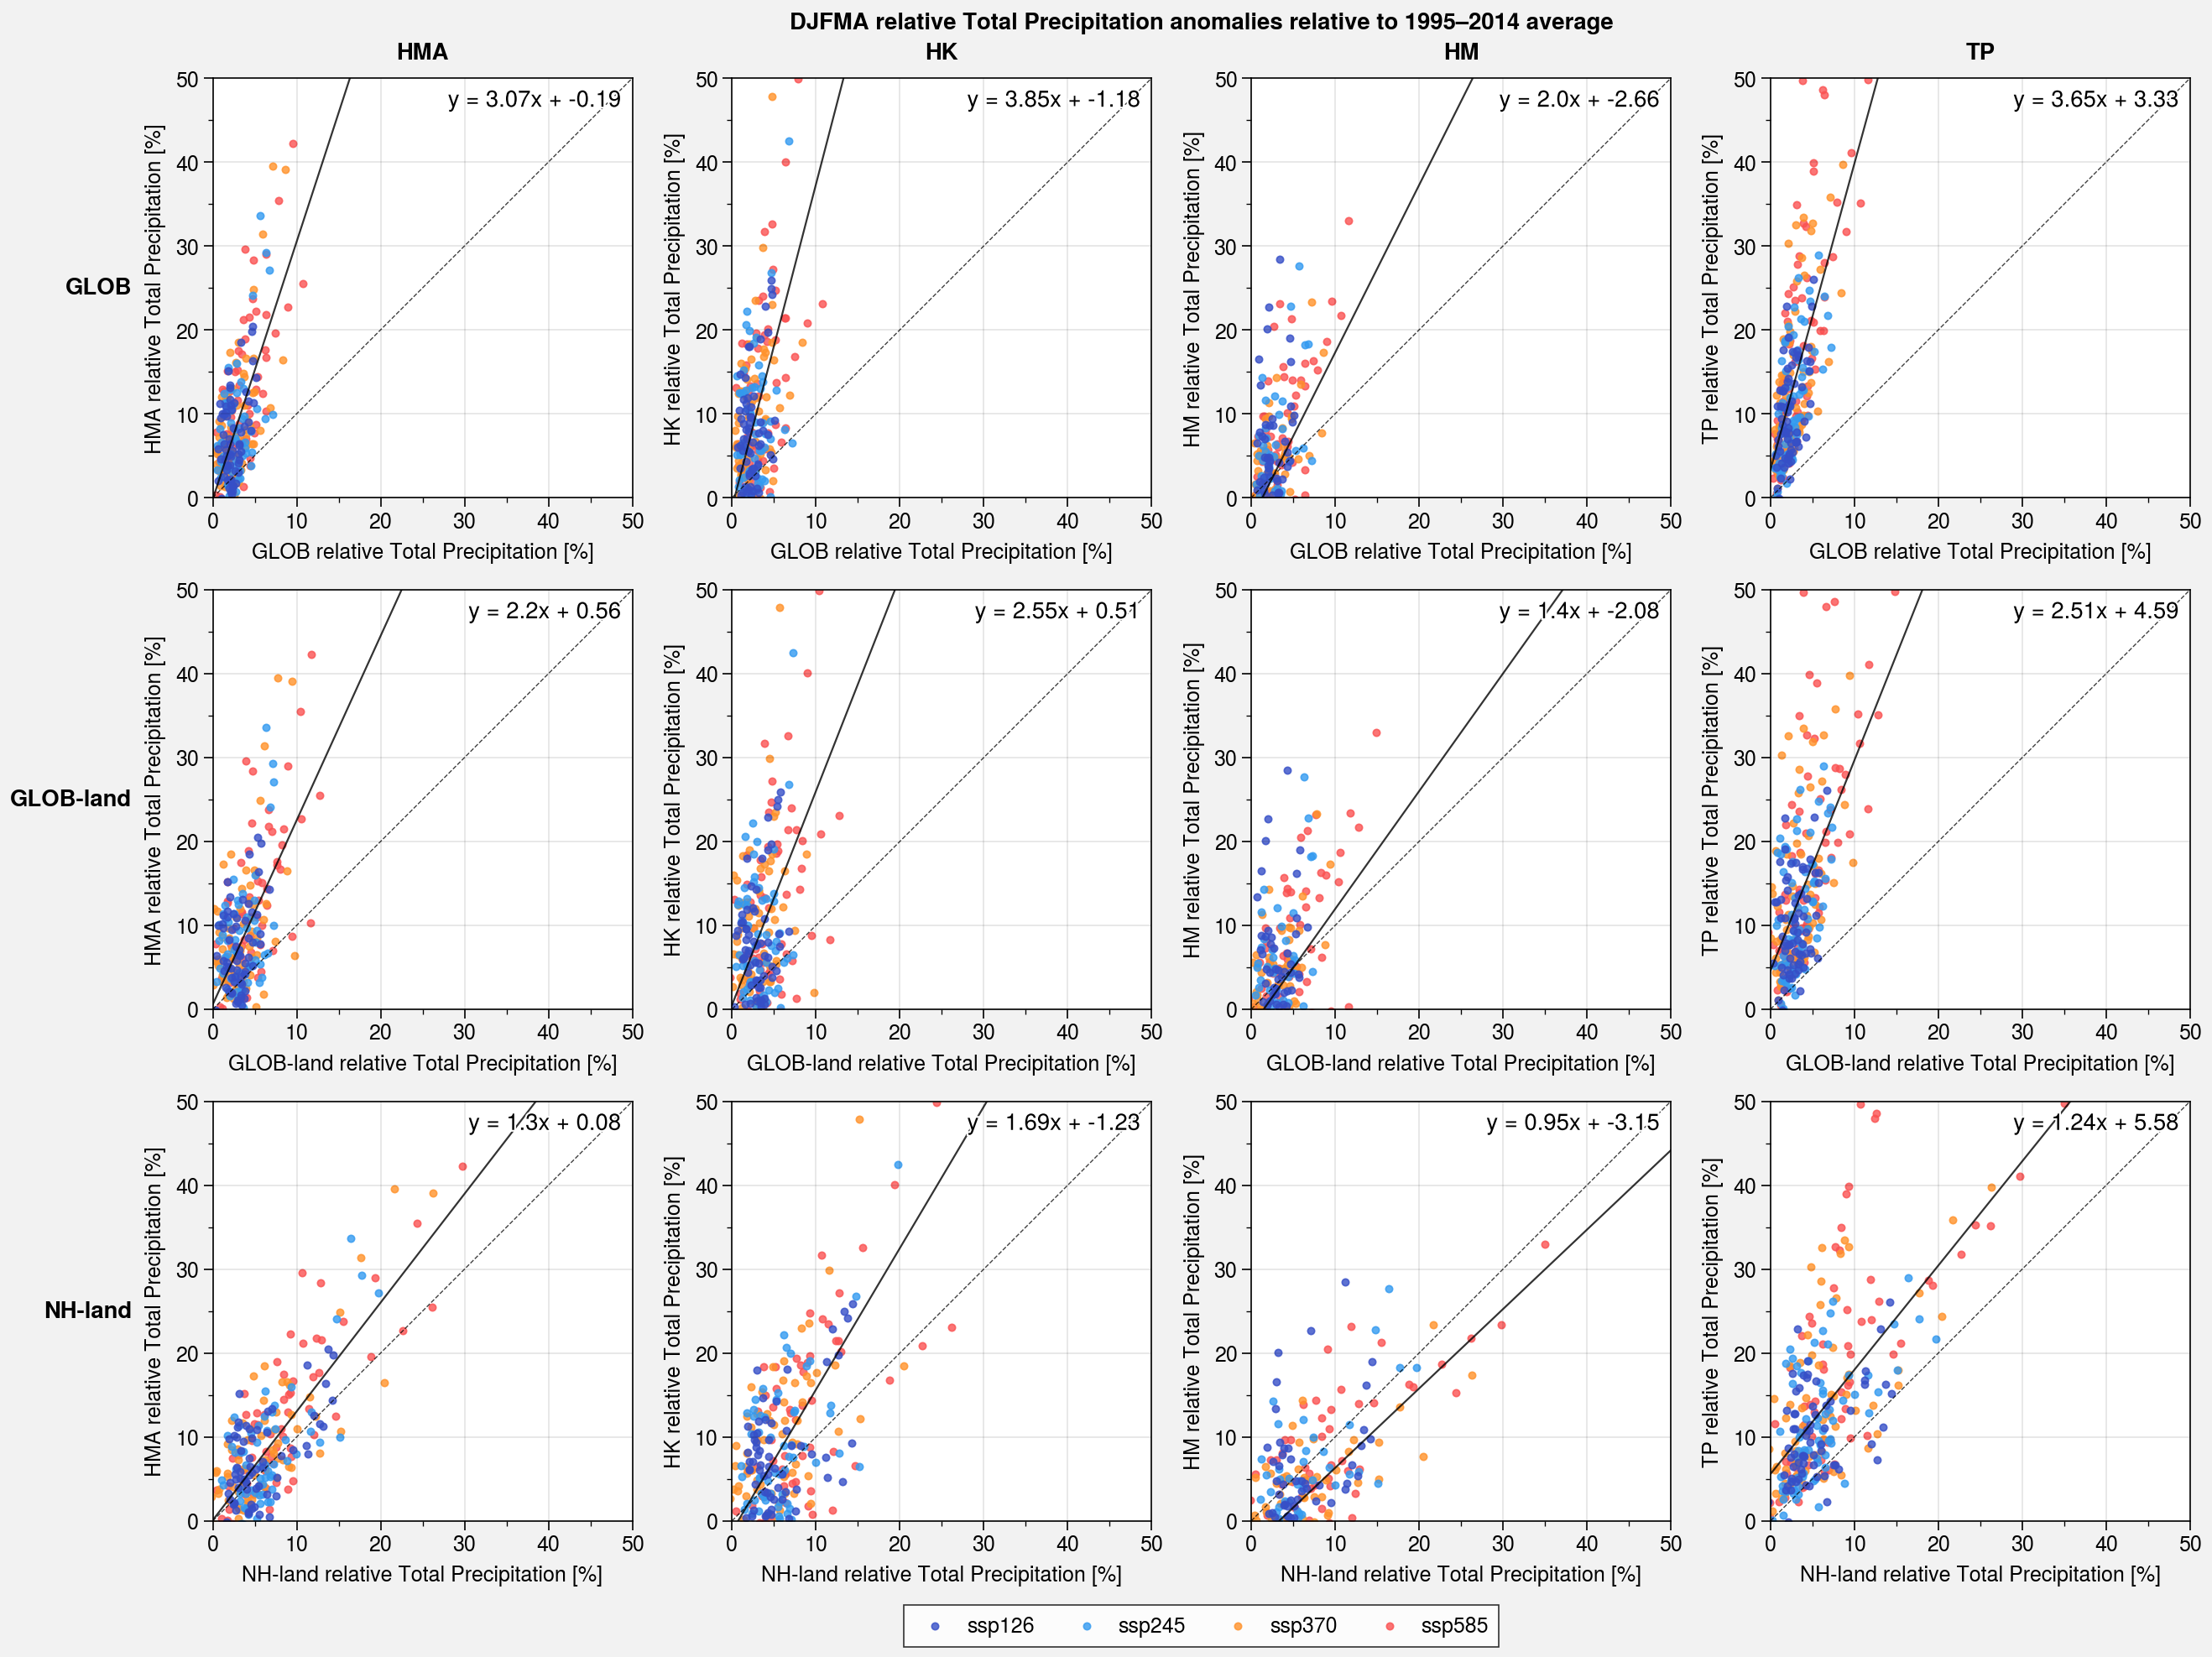

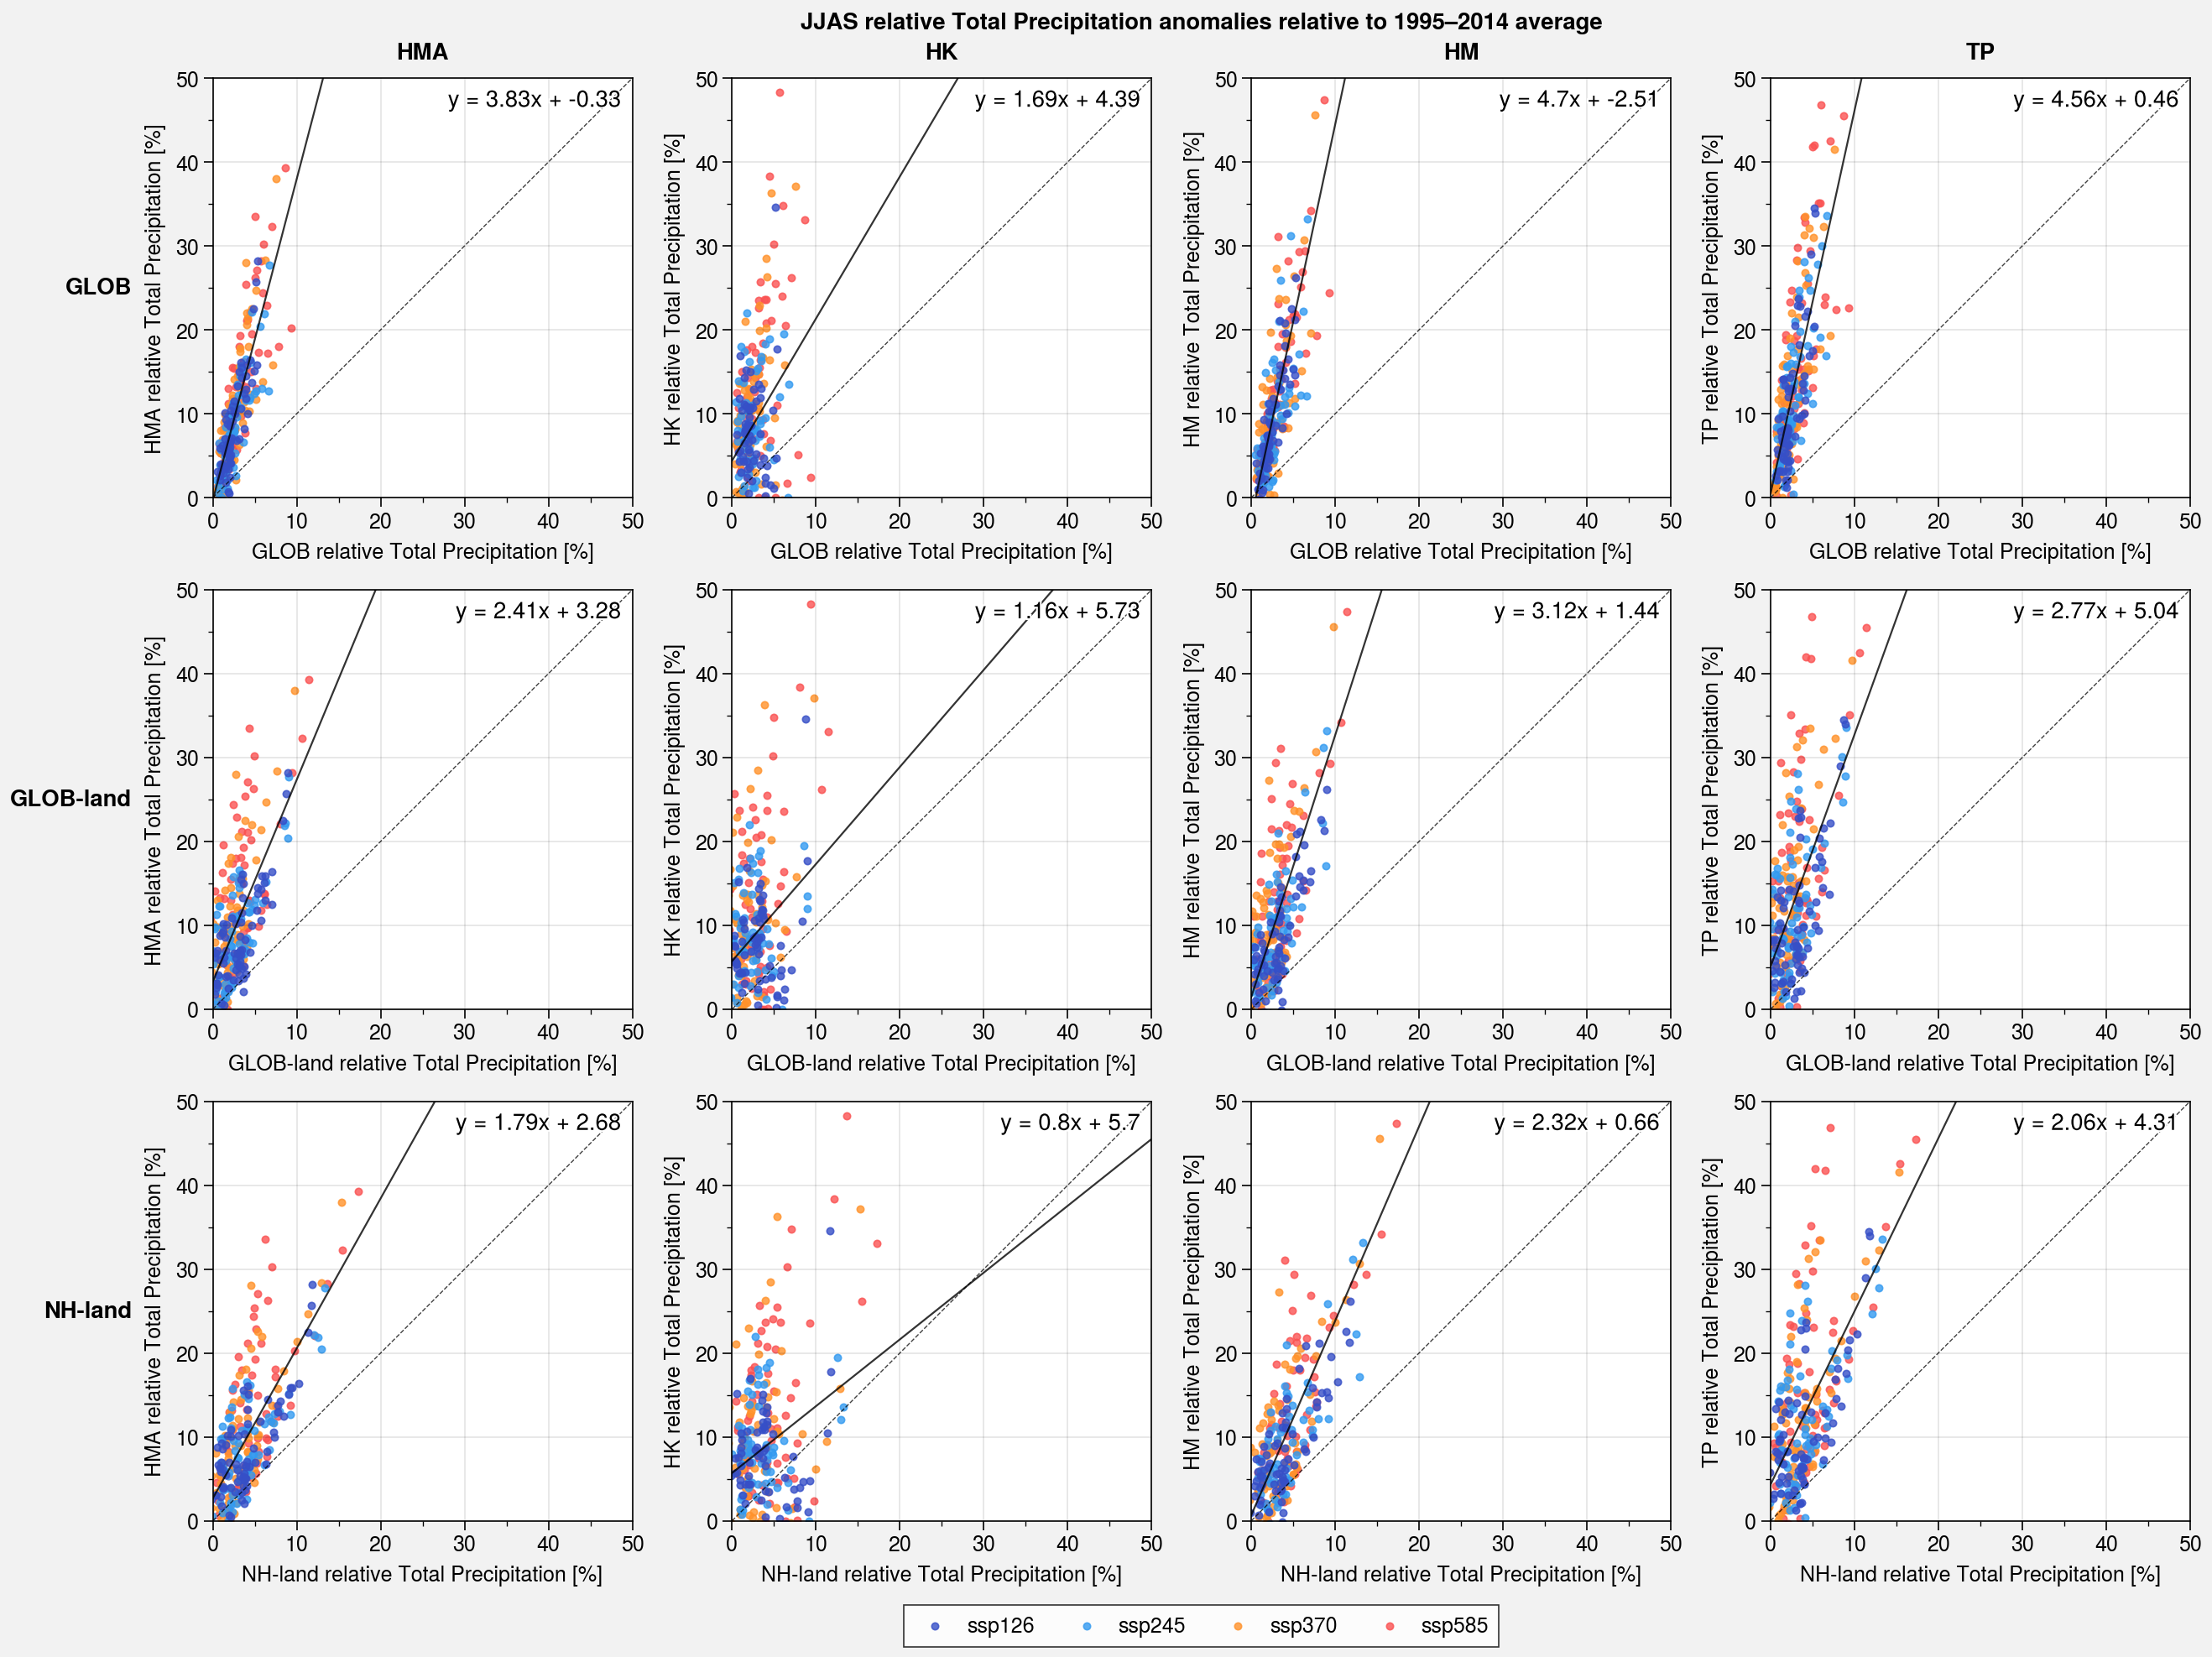

In [12]:
colors = ['indigo9', 'blue5', 'orange5', 'red6']
marker = '.'
alpha = 0.8

for var in variables:
# for var in ['tas']:
    print('***********')
    print('*** '+var+' ***')
    print('***********')
    label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    if var in ['pr', 'snc']: # relative
        units = '%'
        label = 'relative ' + label
    
    for season in seasons:
#     for season in ['Annual']:

        # Figure
        fig, axs = plot.subplots(ncols=4, nrows=3, share=0)
        k=0
        for x_zone in zones[:3]:
            for zone in zones[3:]:
                for i, scenario in enumerate(scenarios):
                    if k == 0:
                        axs[k].scatter(
                            df.loc[(season, scenario), (var, x_zone)], 
                            df.loc[(season, scenario), (var, zone)], 
                            color=colors[i], label=scenario, zorder=-i, marker=marker, alpha=alpha
                        )
                    else:
                        axs[k].scatter(
                            df.loc[(season, scenario), (var, x_zone)], 
                            df.loc[(season, scenario), (var, zone)], 
                            color=colors[i], zorder=-i, marker=marker, alpha=alpha
                        )
                
                if var == 'tas':
                    xlims=(0,10); ylims=(0,10); xlocator=2; xminorlocator=1.00001
                elif var in ['snc']:
                    xlims=(0,-100); ylims=(-100,0); xlocator=20; xminorlocator=10
                elif var in ['pr']:
                    xlims=(0,50); ylims=(0,50); xlocator=10; xminorlocator=5

                axs[k].format(
                    xlabel=x_zone + ' ' + label + ' ['+units+']', 
                    ylabel=zone + ' ' + label + ' ['+units+']', 
                    xlim=xlims, ylim=ylims,
                    xlocator=xlocator, xminorlocator=xminorlocator,
                    ylocator=xlocator, yminorlocator=xminorlocator,
                )
                
                # Regression
                axs[k].plot(ylims, ylims, 'k--', alpha=0.75, zorder=0, linewidth=0.5)

                reg = stats.linregress(
                    np.concatenate(df.loc[(season), (var, x_zone)]), 
                    np.concatenate(df.loc[(season), (var, zone)])
                )
                x = np.array(xlims)
                y = reg.slope*x + reg.intercept
                axs[k].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

                if var in ['tas']:
                    axs[k].format(ultitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
                else:
                    axs[k].format(urtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
                
                
                k += 1


        axs.format(
            suptitle = season + ' ' + label + ' anomalies relative to 1995–2014 average',
            collabels = zones[3:],
            rowlabels = zones[:3]
        )

        fig.legend(loc='b', frame=True, ncols=4)

        filename = 'projections/'+var+'_'+season+'_HMA-vs-global'
        fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

## var vs tas

In [ ]:
colors = ['indigo9', 'blue5', 'orange5', 'red6']
marker = '.'
alpha = 0.8

# for var in variables:
for var in ['snc', 'pr']:
    print('***********')
    print('*** '+var+' ***')
    print('***********')
    label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    if var in ['pr', 'snc']: # relative
        units = '%'
        label = 'relative ' + label
    
    for season in seasons:
#     for season in ['Annual']:

        # Figure
        fig, axs = plot.subplots(ncols=4, nrows=4, share=0)
        k=0
        for x_zone in zones[:4]:
            for zone in zones[3:]:
                for i, scenario in enumerate(scenarios):
                    if k == 0:
                        axs[k].scatter(
                            df.loc[(season, scenario), ('tas', x_zone)], 
                            df.loc[(season, scenario), (var, zone)], 
                            color=colors[i], label=scenario, zorder=-i, marker=marker, alpha=alpha
                        )
                    else:
                        axs[k].scatter(
                            df.loc[(season, scenario), ('tas', x_zone)], 
                            df.loc[(season, scenario), (var, zone)], 
                            color=colors[i], zorder=-i, marker=marker, alpha=alpha
                        )
                
                if var == 'tas':
                    xlims=(0,10); ylims=(0,10)
                    xlocator=2; xminorlocator=1.00001
                    ylocator=2; yminorlocator=1.00001
                elif var in ['snc']:
                    xlims=(0,10); ylims=(-100,0)
                    xlocator=2; xminorlocator=1.00001
                    ylocator=20; yminorlocator=10
                elif var in ['pr']:
                    xlims=(0,10); ylims=(0,50)
                    xlocator=2; xminorlocator=1.00001
                    ylocator=10; yminorlocator=5

                axs[k].format(
                    xlabel=x_zone + ' Near-Surface Air Temperature [°C]',
                    ylabel=zone + ' ' + label + ' ['+units+']',  
                    xlim=xlims, ylim=ylims,
                    xlocator=xlocator, xminorlocator=xminorlocator,
                    ylocator=ylocator, yminorlocator=yminorlocator,
                )
                
                # Regression
#                 axs[k].plot(ylims, ylims, 'k--', alpha=0.75, zorder=0, linewidth=0.5)

                reg = stats.linregress(
                    np.concatenate(df.loc[(season), ('tas', x_zone)]), 
                    np.concatenate(df.loc[(season), (var, zone)])
                )
                x = np.array(xlims)
                y = reg.slope*x + reg.intercept
                axs[k].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

                if var in ['tas']:
                    axs[k].format(ultitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
                else:
                    axs[k].format(urtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
                
                
                k += 1


        axs.format(
            suptitle = season + ' ' + label + ' anomalies relative to 1995–2014 average',
            collabels = zones[3:],
            rowlabels = zones[:4]
        )

        fig.legend(loc='b', frame=True, ncols=4)

        filename = 'projections/'+var+'_'+season+'_HMA-vs-tas_global'
        fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

***********
*** snc ***
***********
***********
*** pr ***
***********


# Old plots

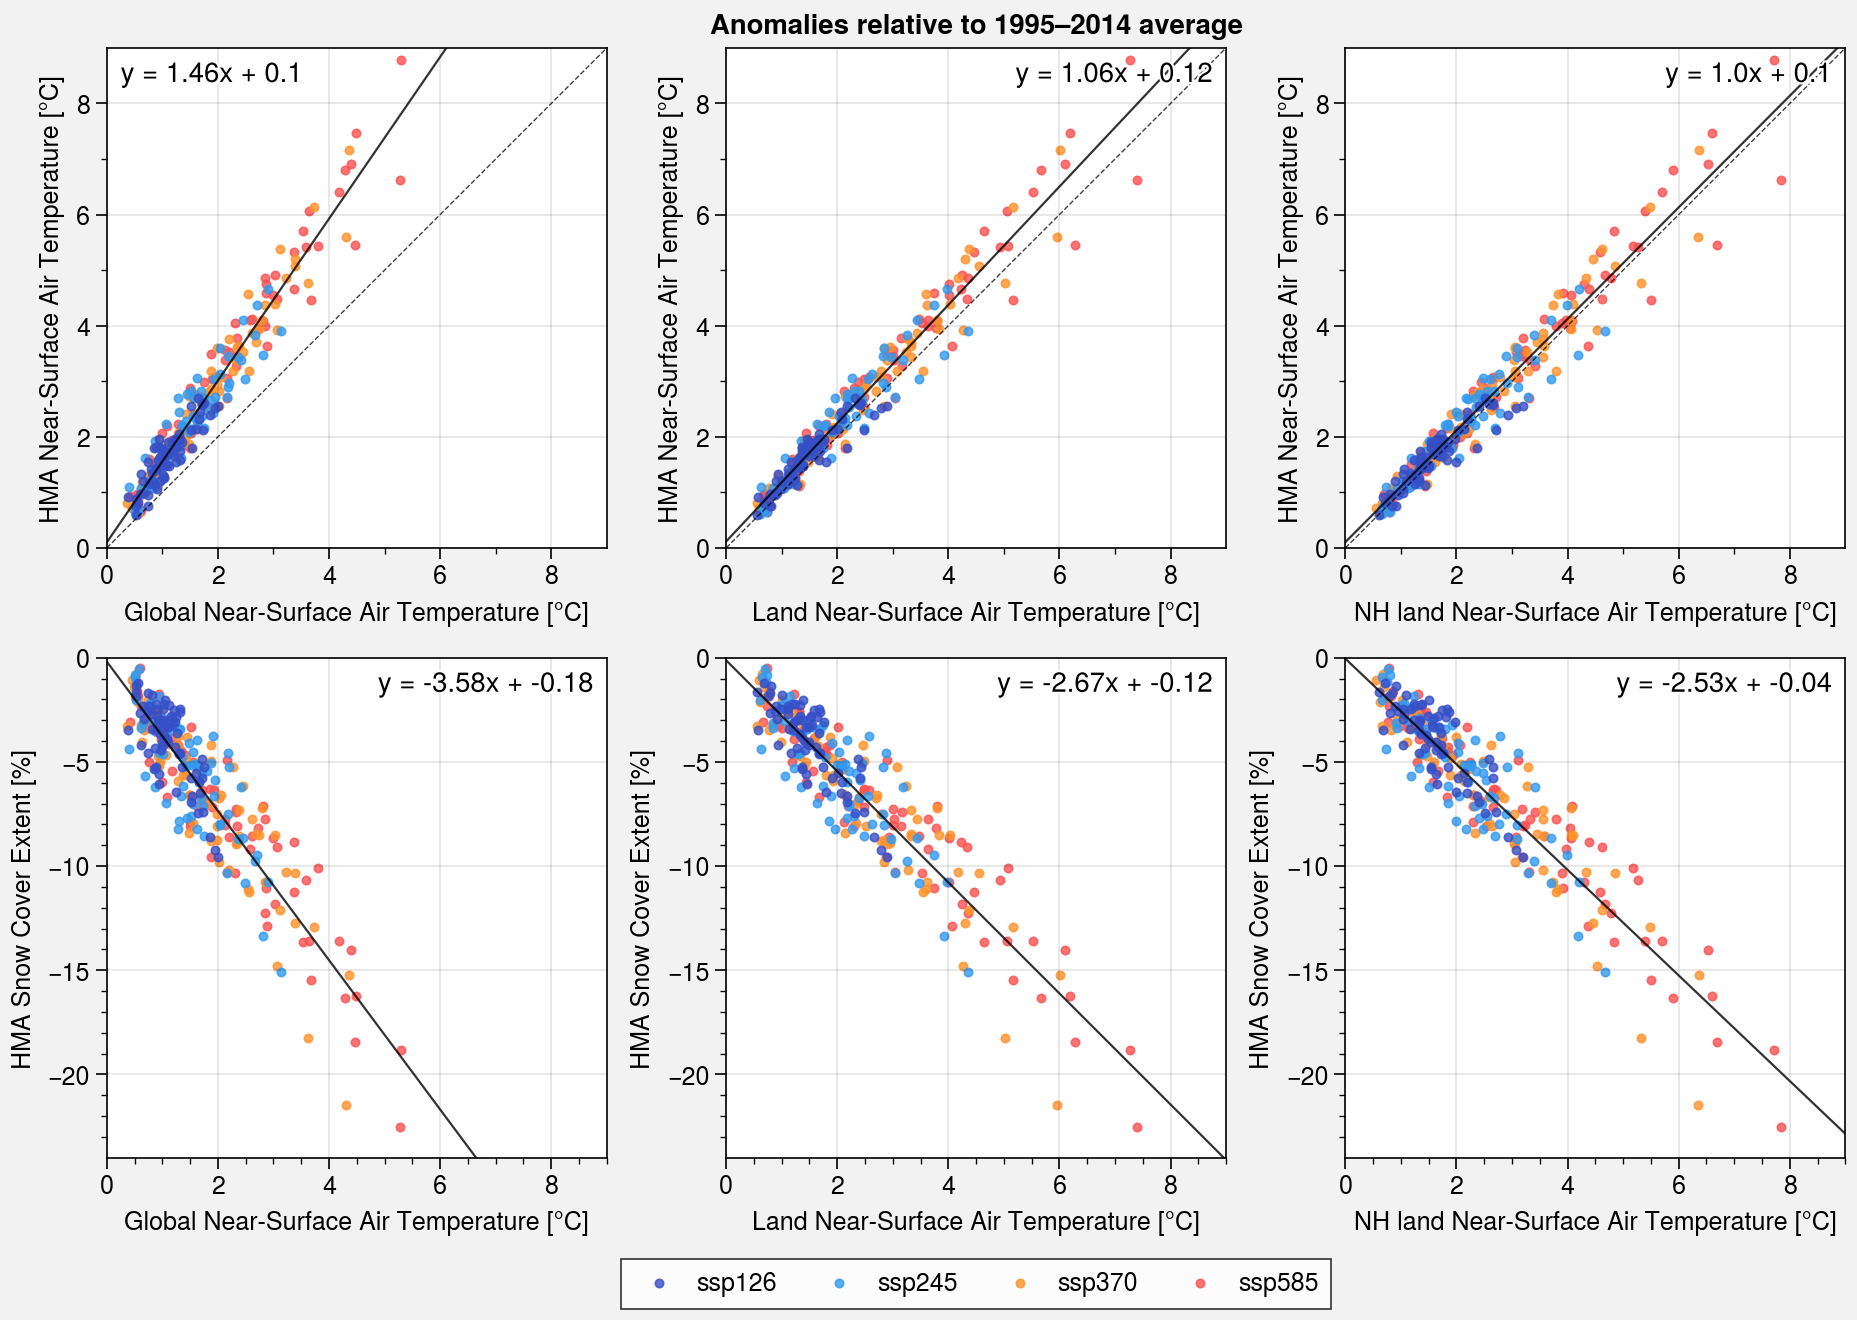

In [8]:
colors = ['indigo9', 'blue5', 'orange5', 'red6']
marker = '.'
alpha = 0.8

# To store results for regression
HMA_tas_all = []; GLOB_tas_all = []; GLOB_land_tas_all = []; NH_land_tas_all = []
HMA_snc_all = []; GLOB_snc_all = []


# Figure
fig, axs = plot.subplots(ncols=3, nrows=2, share=0)

for i, scenario in enumerate(scenarios):
    # tas
    axs[0].scatter(df.loc[scenario, ("tas", "GLOB")], df.loc[scenario, ("tas", "HMA")], color=colors[i], label=scenario, zorder=-i, marker=marker, alpha=alpha)
    axs[1].scatter(df.loc[scenario, ("tas", "GLOB-land")], df.loc[scenario, ("tas", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    axs[2].scatter(df.loc[scenario, ("tas", "NH-land")], df.loc[scenario, ("tas", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    
    # snc
    axs[3].scatter(df.loc[scenario, ("tas", "GLOB")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    axs[4].scatter(df.loc[scenario, ("tas", "GLOB-land")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    axs[5].scatter(df.loc[scenario, ("tas", "NH-land")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    
    HMA_tas_all.append(df.loc[scenario, ("tas", "HMA")]); GLOB_tas_all.append(df.loc[scenario, ("tas", "GLOB")])
    GLOB_land_tas_all.append(df.loc[scenario, ("tas", "GLOB-land")]); NH_land_tas_all.append(df.loc[scenario, ("tas", "NH-land")])
    HMA_snc_all.append(df.loc[scenario, ("snc", "HMA")]); GLOB_snc_all.append(df.loc[scenario, ("snc", "GLOB")])

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
HMA_tas_all = [item for sublist in HMA_tas_all for item in sublist]
GLOB_tas_all = [item for sublist in GLOB_tas_all for item in sublist]
GLOB_land_tas_all = [item for sublist in GLOB_land_tas_all for item in sublist]
NH_land_tas_all = [item for sublist in NH_land_tas_all for item in sublist]
HMA_snc_all = [item for sublist in HMA_snc_all for item in sublist]
GLOB_snc_all = [item for sublist in GLOB_snc_all for item in sublist]
    

lim = (0,9)
tas_zone = ['Global', 'Land', 'NH land']
for i in range(3):
    axs[i].format(
        xlim=lim, ylim=lim,
        xlabel=tas_zone[i]+' Near-Surface Air Temperature [°C]',
        ylabel='HMA Near-Surface Air Temperature [°C]',
        xlocator=2, xminorlocator=1.00001,
        ylocator=2, yminorlocator=1.00001,
    )

min_snc = -24
for i in range(3,6):
    axs[i].format(
        xlim=lim, ylim=(min_snc, 0),
        xlabel=tas_zone[i-3]+' Near-Surface Air Temperature [°C]',
        ylabel='HMA Snow Cover Extent [%]'
    )

# https://stackoverflow.com/questions/25497402/adding-y-x-to-a-matplotlib-scatter-plot-if-i-havent-kept-track-of-all-the-data
xy_list = [
    [GLOB_tas_all, HMA_tas_all], [GLOB_land_tas_all, HMA_tas_all], [NH_land_tas_all, HMA_tas_all],
    [GLOB_tas_all, HMA_snc_all], [GLOB_land_tas_all, HMA_snc_all], [NH_land_tas_all, HMA_snc_all],
]
for i, ax in enumerate(axs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=0.5)
    
    # Plot regression
    reg = stats.linregress(xy_list[i][0], xy_list[i][1])
    x = np.array(lims)
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
    
    if i == 0:
        ax.format(ultitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
    else:
        ax.format(urtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
        
    
axs.format(
    suptitle='Anomalies relative to 1995–2014 average'
)

fig.legend(loc='b', frame=True, ncols=4)

filename = 'projections/all_HMA_global_land'
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

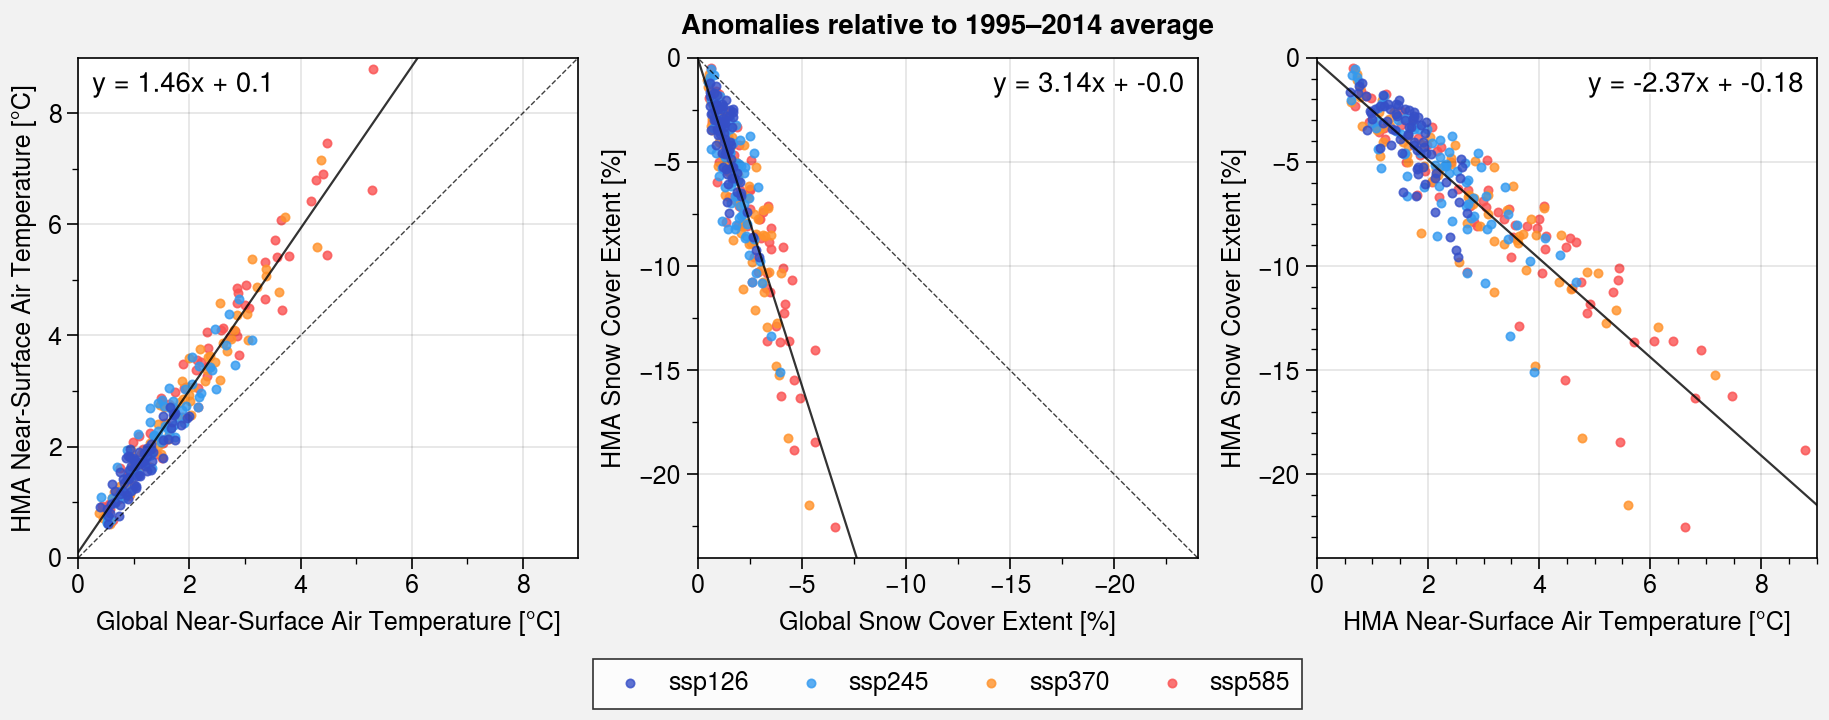

In [126]:
colors = ['indigo9', 'blue5', 'orange5', 'red6']
marker = '.'
alpha = 0.8

# To store results for regression
HMA_tas_all = []
GLOB_tas_all = []
HMA_snc_all = []
GLOB_snc_all = []


# Figure
fig, axs = plot.subplots(ncols=3, nrows=1, share=0)

for i, scenario in enumerate(scenarios):
    axs[0].scatter(df.loc[scenario, ("tas", "GLOB")], df.loc[scenario, ("tas", "HMA")], color=colors[i], label=scenario, zorder=-i, marker=marker, alpha=alpha)
    axs[1].scatter(df.loc[scenario, ("snc", "GLOB")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    axs[2].scatter(df.loc[scenario, ("tas", "HMA")], df.loc[scenario, ("snc", "HMA")], color=colors[i], zorder=-i, marker=marker, alpha=alpha)
    
    HMA_tas_all.append(df.loc[scenario, ("tas", "HMA")])
    GLOB_tas_all.append(df.loc[scenario, ("tas", "GLOB")])
    HMA_snc_all.append(df.loc[scenario, ("snc", "HMA")])
    GLOB_snc_all.append(df.loc[scenario, ("snc", "GLOB")])

# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
HMA_tas_all = [item for sublist in HMA_tas_all for item in sublist]
GLOB_tas_all = [item for sublist in GLOB_tas_all for item in sublist]
HMA_snc_all = [item for sublist in HMA_snc_all for item in sublist]
GLOB_snc_all = [item for sublist in GLOB_snc_all for item in sublist]
    

lim = (0,9)
axs[0].format(
    xlim=lim, ylim=lim,
    xlabel='Global Near-Surface Air Temperature [°C]',
    ylabel='HMA Near-Surface Air Temperature [°C]',
    xlocator=2, xminorlocator=1.00001,
    ylocator=2, yminorlocator=1.00001,
)

min_snc = -24
axs[1].format(
    xlim=(0,min_snc), ylim=(min_snc,0),
    xlabel='Global Snow Cover Extent [%]',
    ylabel='HMA Snow Cover Extent [%]',
    xlocator=5, xminorlocator=2.5,
    ylocator=5, yminorlocator=2.5,
)

axs[2].format(
    xlim=lim, ylim=(min_snc, 0),
    xlabel='HMA Near-Surface Air Temperature [°C]',
    ylabel='HMA Snow Cover Extent [%]'
)

# https://stackoverflow.com/questions/25497402/adding-y-x-to-a-matplotlib-scatter-plot-if-i-havent-kept-track-of-all-the-data
xy_list = [
    [GLOB_tas_all, HMA_tas_all],
    [GLOB_snc_all, HMA_snc_all],
    [HMA_tas_all, HMA_snc_all]
]
for i, ax in enumerate(axs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=0.5)
    
    # Plot regression
    reg = stats.linregress(xy_list[i][0], xy_list[i][1])
    x = np.array(lims)
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
    
    if i == 0:
        ax.format(ultitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
    else:
        ax.format(urtitle='y = ' + str(round(reg.slope, 2)) + 'x + ' + str(round(reg.intercept, 2)))
        
    
axs.format(
    suptitle='Anomalies relative to 1995–2014 average'
)

fig.legend(loc='b', frame=True, ncols=4)

filename = 'projections/all_HMA_global'
# fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')